# Librerias

In [9]:
! pip install sweetviz
! pip install catboost

In [57]:
import sys
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sweetviz as sv
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import layers, initializers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import itertools

# Importación de los datos

In [11]:
# Load the data from the specified path
df = pd.read_csv(r'Telecom.csv', delimiter=(';'))

In [12]:
df.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  ...  Total eve charge  \
0             45.07              197.4  ...             16.78   
1             27.47              195.5  ...             16.62   
2             41.38              121.2  ...             10.30   
3             50.90               61.9  ...              5.26   
4             28.34              148.3  ...             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  Internet plan  \
0                10.0                 3               2.70            Yes   
1                13.7                 3               3.70            Yes   
2                12.2                 5               3.29             No   
3                 6.6                 7               1.78             No   
4                10.1                 3               2.73             No   

  Customer service calls  Churn  
0                      1  False  
1                      1  False  
2                      0  False  
3                      2  False  
4                      3  False  

[5 rows x 21 columns]

# Limpieza de los datos

In [13]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Internet plan',
       'Customer service calls', 'Churn'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3395 non-null   object 
 1   Account length          3395 non-null   int64  
 2   Area code               3395 non-null   int64  
 3   International plan      3395 non-null   object 
 4   Voice mail plan         3395 non-null   object 
 5   Number vmail messages   3395 non-null   int64  
 6   Total day minutes       3395 non-null   float64
 7   Total day calls         3395 non-null   int64  
 8   Total day charge        3395 non-null   float64
 9   Total eve minutes       3395 non-null   float64
 10  Total eve calls         3395 non-null   int64  
 11  Total eve charge        3395 non-null   float64
 12  Total night minutes     3395 non-null   float64
 13  Total night calls       3395 non-null   int64  
 14  Total night charge      3395 non-null   

In [15]:
print(df.nunique())

State                       51
Account length             212
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       46
Total day minutes         1667
Total day calls            119
Total day charge          1667
Total eve minutes         1611
Total eve calls            123
Total eve charge          1440
Total night minutes       1591
Total night calls          120
Total night charge         933
Total intl minutes         162
Total intl calls            21
Total intl charge          162
Internet plan                2
Customer service calls      10
Churn                        2
dtype: int64


In [16]:
df.shape

(3395, 21)

In [17]:
df.select_dtypes(include=['object'])

State International plan Voice mail plan Internet plan
0       KS                 No             Yes           Yes
1       OH                 No             Yes           Yes
2       NJ                 No              No            No
3       OH                Yes              No            No
4       OK                Yes              No            No
...    ...                ...             ...           ...
3390    DE                 No              No            No
3391    ME                Yes             Yes           Yes
3392    NJ                 No              No            No
3393    NV                 No              No            No
3394    MO                 No             Yes           Yes

[3395 rows x 4 columns]

Luego vamos a pasar las columnas 'International plan', 'Voice mail plan', 'Internet plan' de categoricas a numéricas, es decir el valor Yes sera 1, y el valor No sera 0.

In [18]:
df['International plan'] = df['International plan'].str.strip().str.lower().replace({'yes': 1, 'no': 0})
df['Voice mail plan'] = df['Voice mail plan'].str.strip().str.lower().replace({'yes': 1, 'no': 0})
df['Internet plan'] = df['Internet plan'].str.strip().str.lower().replace({'yes': 1, 'no': 0})
df['Churn'] = df['Churn'].astype('str')
df['Churn'] = df['Churn'].replace({'False': 0, 'True': 1})

In [19]:
df

State  Account length  Area code  International plan  Voice mail plan  \
0       KS             128        415                   0                1   
1       OH             107        415                   0                1   
2       NJ             137        415                   0                0   
3       OH              84        408                   1                0   
4       OK              75        415                   1                0   
...    ...             ...        ...                 ...              ...   
3390    DE             125        408                   0                0   
3391    ME              36        510                   1                1   
3392    NJ              64        510                   0                0   
3393    NV              74        415                   0                0   
3394    MO             112        510                   0                1   

      Number vmail messages  Total day minutes  Total day calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3390                      0              126.7              108   
3391                     42              196.8               89   
3392                      0              162.6               83   
3393                      0              282.5              114   
3394                     36              113.7              117   

      Total day charge  Total eve minutes  ...  Total eve charge  \
0                45.07              197.4  ...             16.78   
1                27.47              195.5  ...             16.62   
2                41.38              121.2  ...             10.30   
3                50.90               61.9  ...              5.26   
4                28.34              148.3  ...             12.61   
...                ...                ...  ...               ...   
3390             21.54              206.0  ...             17.51   
3391             33.46              254.9  ...             21.67   
3392             27.64              152.3  ...             12.95   
3393             48.03              219.9  ...             18.69   
3394             19.33              157.5  ...             13.39   

      Total night minutes  Total night calls  Total night charge  \
0                   244.7                 91               11.01   
1                   254.4                103               11.45   
2                   162.6                104                7.32   
3                   196.9                 89                8.86   
4                   186.9                121                8.41   
...                   ...                ...                 ...   
3390                247.8                114               11.15   
3391                138.3                126                6.22   
3392                 57.5                122                2.59   
3393                170.0                115                7.65   
3394                177.6                118                7.99   

      Total intl minutes  Total intl calls  Total intl charge  Internet plan  \
0                   10.0                 3               2.70              1   
1                   13.7                 3               3.70              1   
2                   12.2                 5               3.29              0   
3                    6.6                 7               1.78              0   
4                   10.1                 3               2.73              0   
...                  ...               ...                ...            ...   
3390                13.3                 7               3.59        

El siguiente paso es plotear las variables para ver si existen valores atípicos.

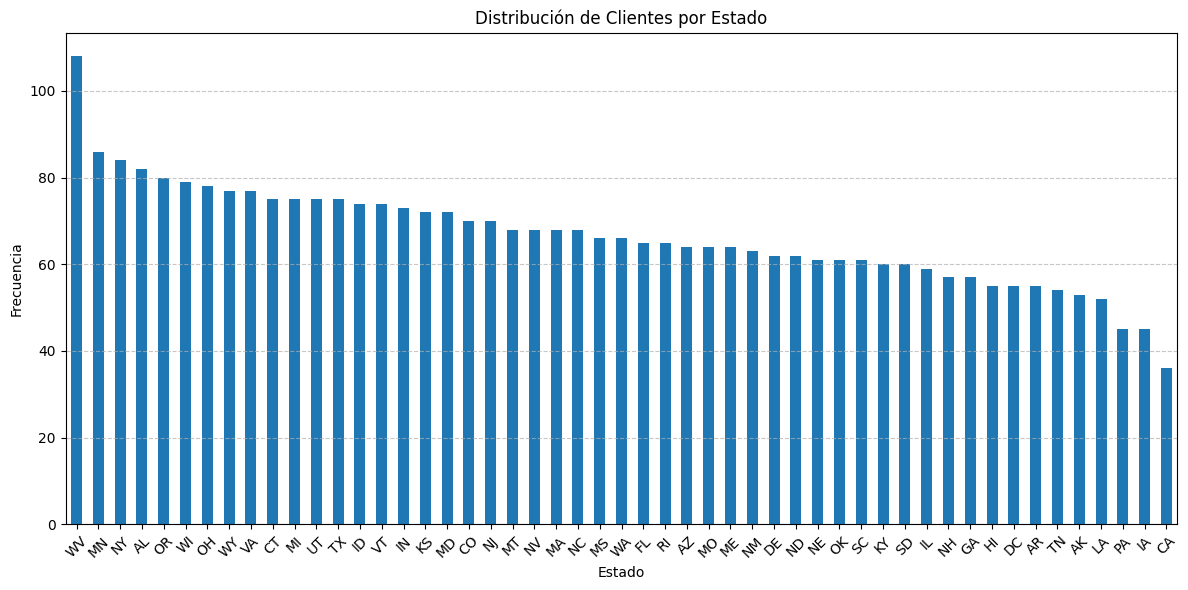

In [20]:
state_counts = df['State'].value_counts()
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.title('Distribución de Clientes por Estado')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una cuadrícula horizontal
plt.tight_layout()  # Ajustar el diseño para evitar que se superpongan los elementos
plt.show()

In [21]:
df = df.drop(['State','Area code'],axis=1)

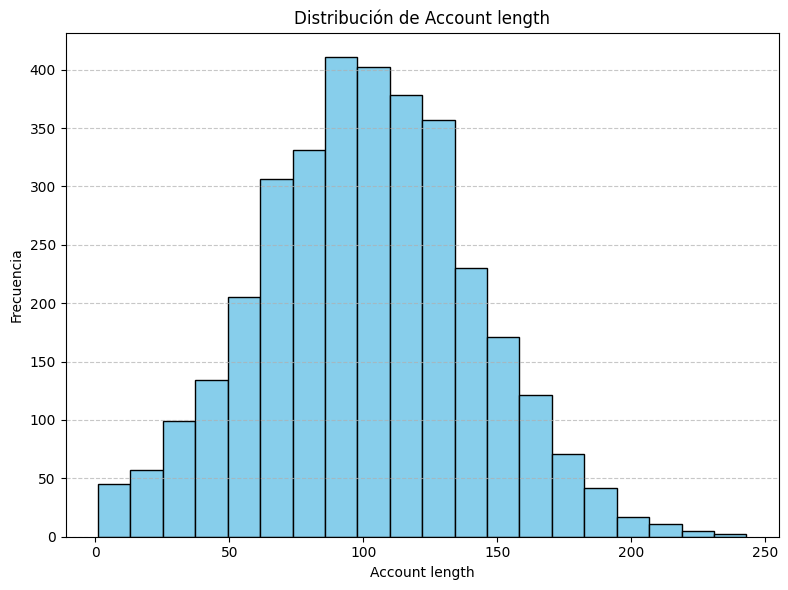

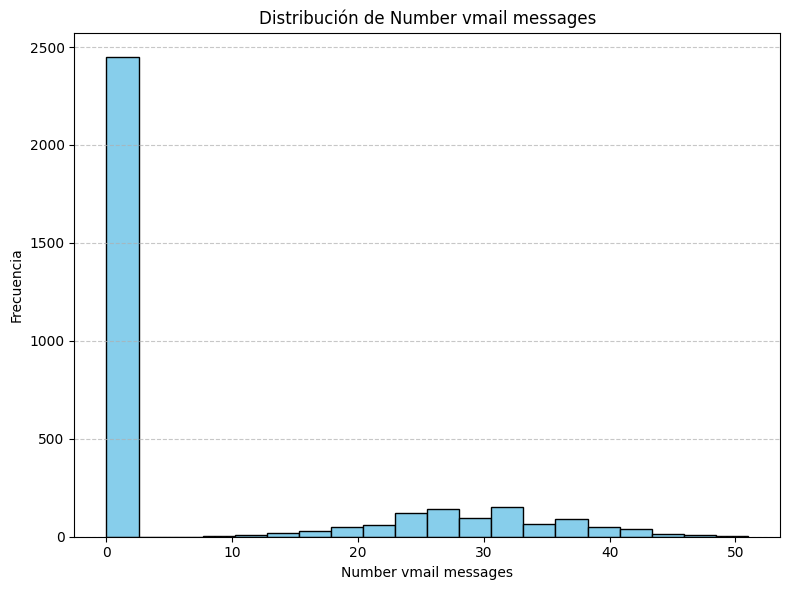

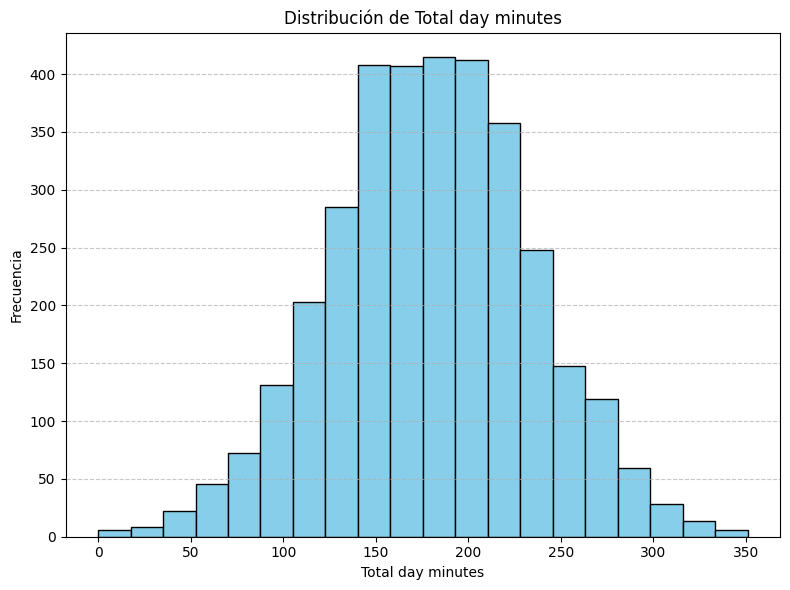

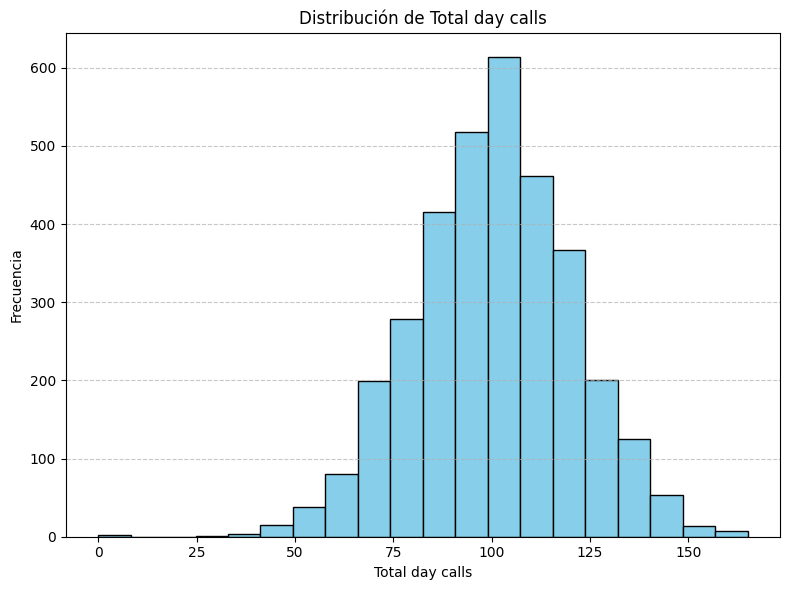

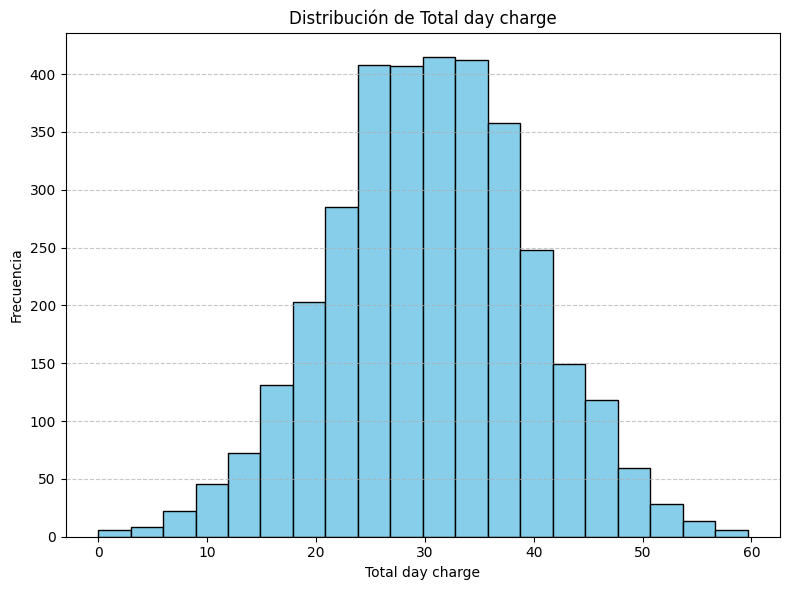

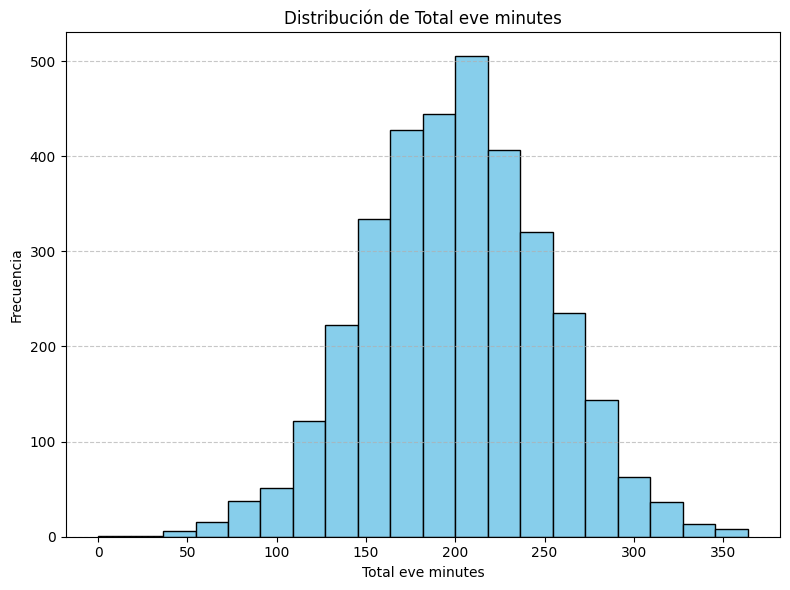

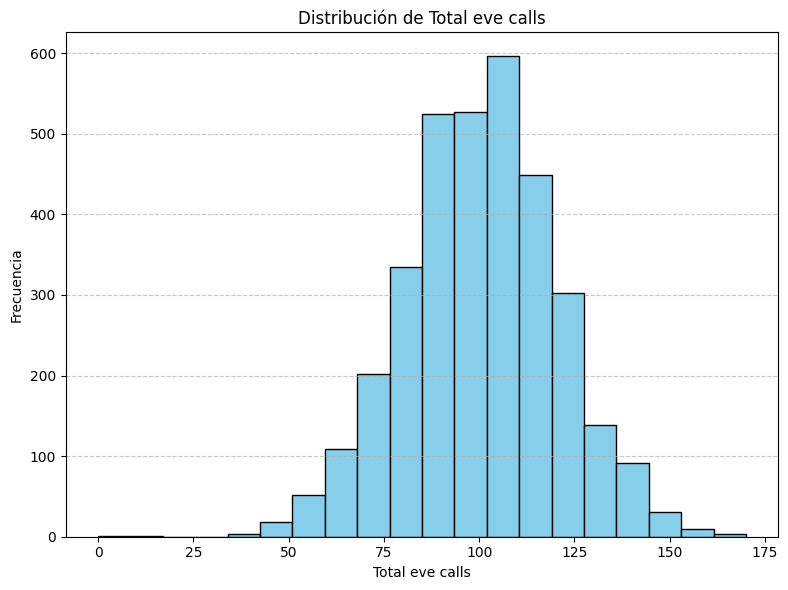

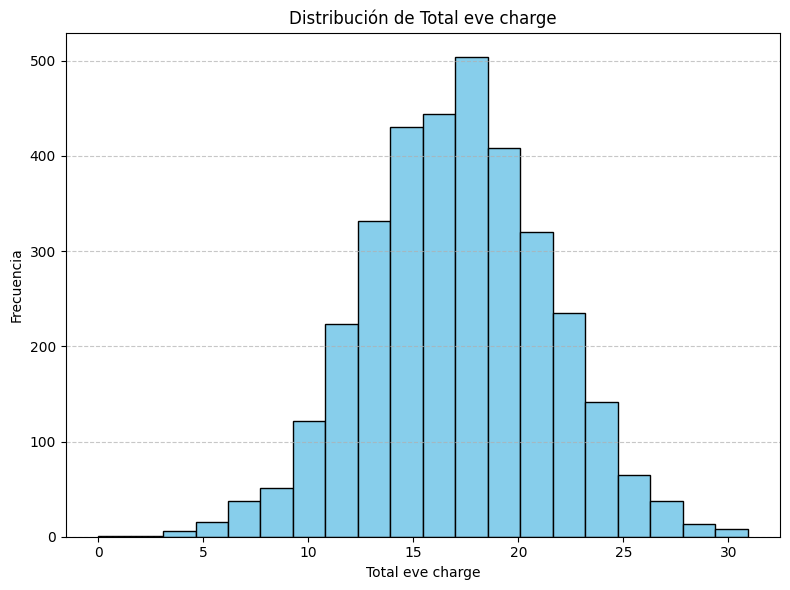

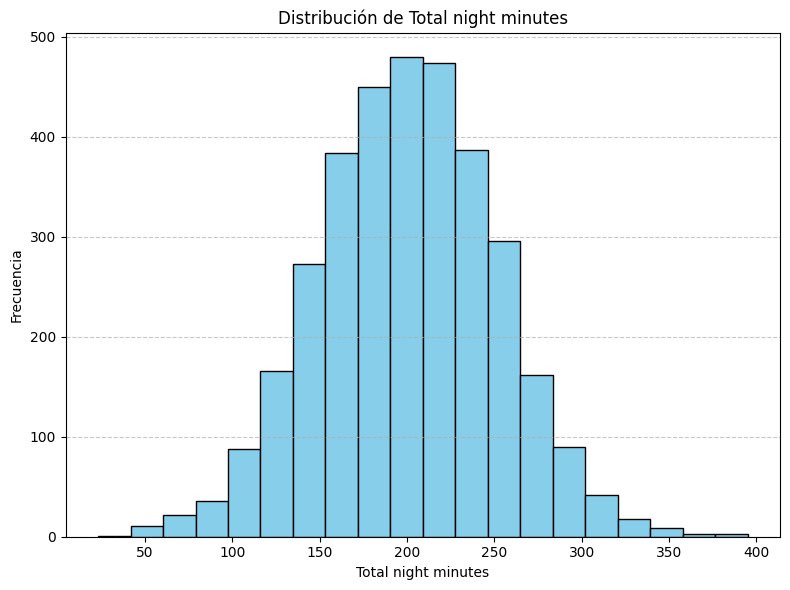

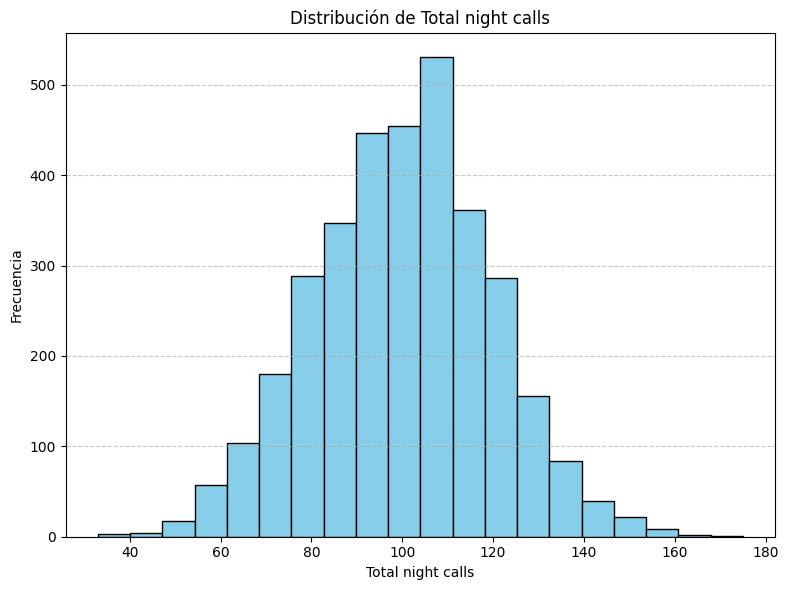

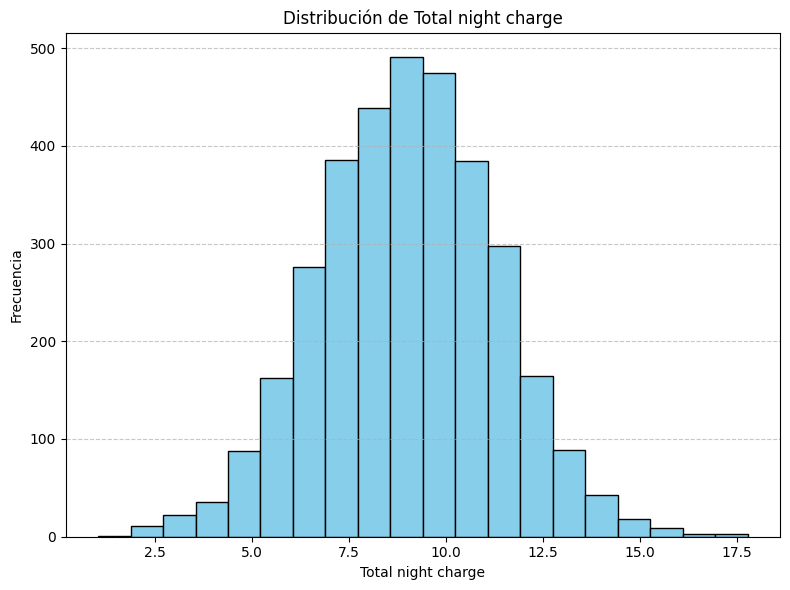

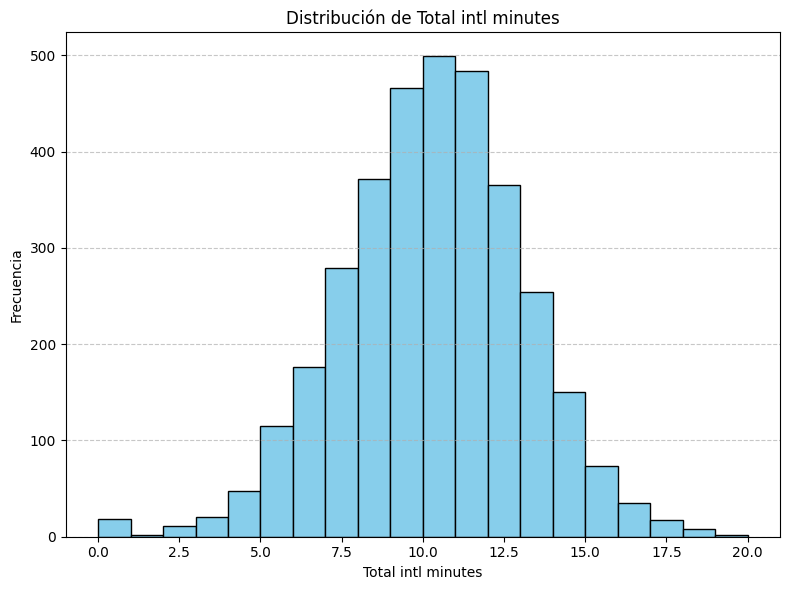

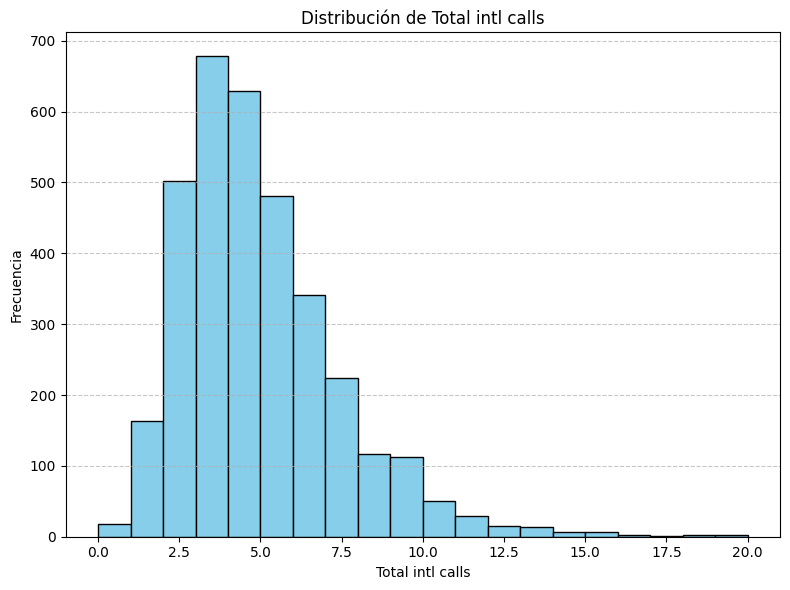

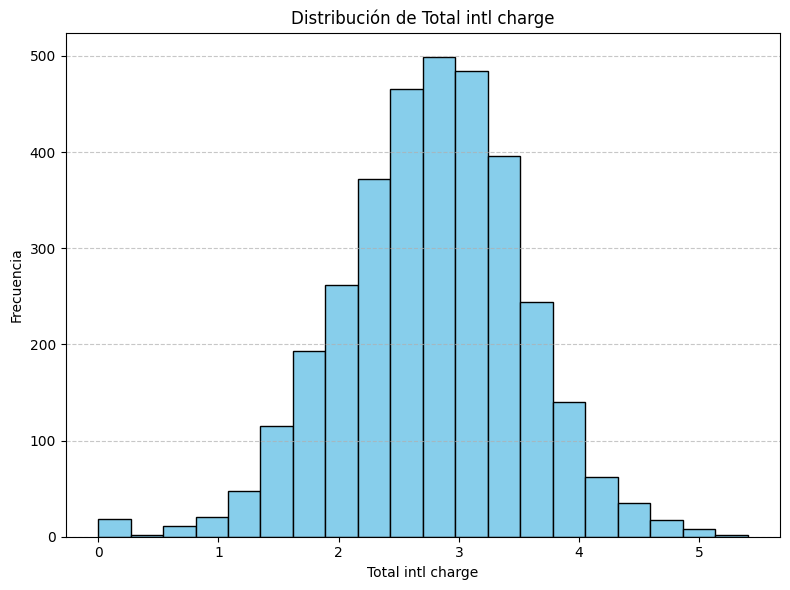

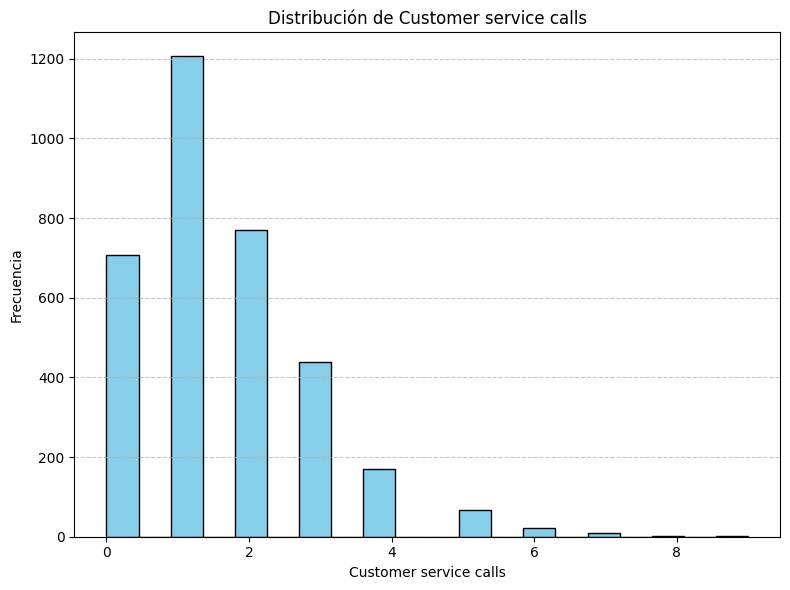

In [22]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

exclude_columns = []
for column in numeric_columns:
    if df[column].nunique() > 2:
        exclude_columns.append(column)

for column in exclude_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

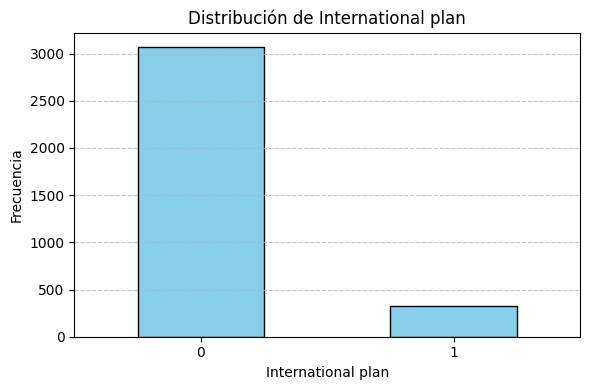

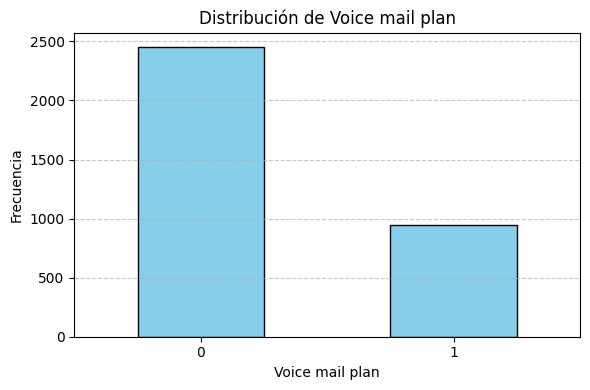

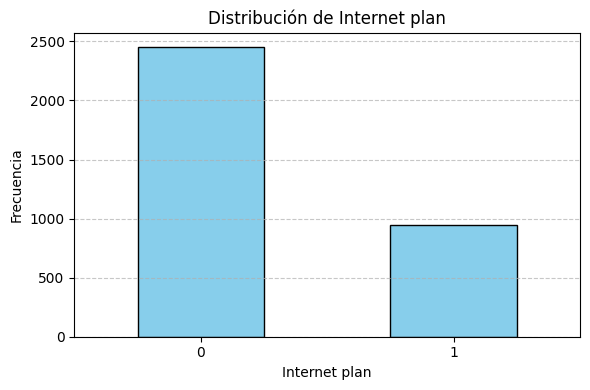

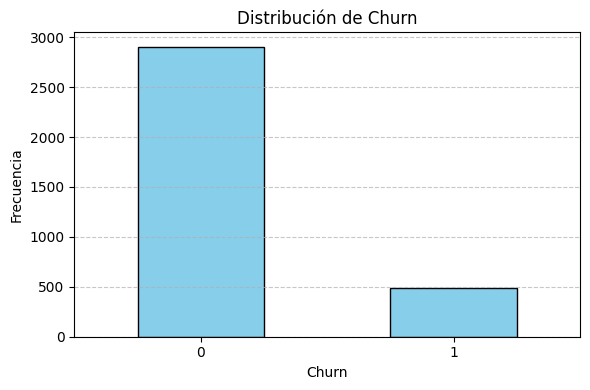

In [23]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
for column in numeric_columns:
    if df[column].nunique() == 2:
        value_counts = df[column].value_counts()
        plt.figure(figsize=(6, 4))
        value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Distribución de {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

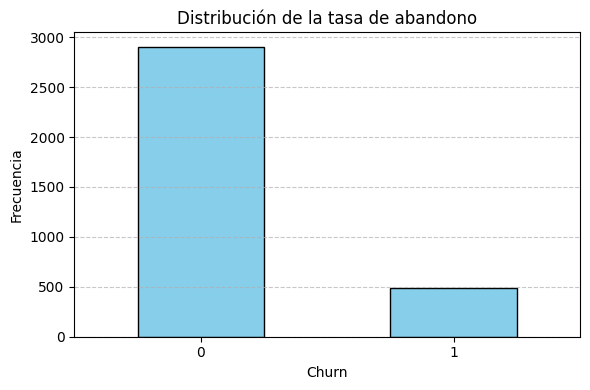

In [24]:
df['Churn'] = df['Churn'].astype(int)

plt.figure(figsize=(6, 4))
df['Churn'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Distribución de la tasa de abandono')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

No parece haber valores atípicos, sin embargo llama la atencio el total de minutos de llamada por la noche, ya que no hay gente que hable poco minutos.

# Análisis estadístico

Primero vamos a imprimir alguna métricas que nos han parecido interesantes para ver como son los datos

In [25]:
total_clients = len(df)
print("Total de clientes:", total_clients)
print('\n')
churn_rate = df['Churn'].mean() * 100
print("Tasa de abandono de cliente: {:.2f}%".format(churn_rate))

call_duration_distribution = df[['Total day minutes', 'Total eve minutes', 'Total night minutes']].describe()
print("Distribución de la duración de las llamadas:\n", call_duration_distribution)
print('\n')
average_daily_calls = df['Total day calls'].mean()
print("Cantidad promedio de llamadas diarias:", average_daily_calls)
print('\n')
average_international_calls = df['Total intl minutes'].mean()
print("Promedio de llamadas internacionales:", average_international_calls)
print('\n')
additional_plans_count = df[['International plan', 'Voice mail plan']].apply(pd.Series.value_counts)
print("Cantidad de clientes con planes adicionales:\n", additional_plans_count)
print('\n')
average_charges = df[['Total day charge', 'Total eve charge', 'Total night charge']].mean()
print("Promedio de cargos diarios, vespertinos y nocturnos:\n", average_charges)

Total de clientes: 3395


Tasa de abandono de cliente: 14.49%
Distribución de la duración de las llamadas:
        Total day minutes  Total eve minutes  Total night minutes
count        3395.000000        3395.000000          3395.000000
mean          179.802180         200.841384           200.590103
std            54.377665          50.659977            50.625799
min             0.000000           0.000000            23.200000
25%           143.700000         166.300000           166.900000
50%           179.400000         201.300000           200.800000
75%           216.200000         235.150000           235.000000
max           350.800000         363.700000           395.000000


Cantidad promedio de llamadas diarias: 100.42650957290132


Promedio de llamadas internacionales: 10.239263622974962


Cantidad de clientes con planes adicionales:
    International plan  Voice mail plan
0                3067             2450
1                 328              945


Promedio de cargos di

In [26]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
non_binary_numeric_columns = []
for column in numeric_columns:
    if df[column].nunique() > 2:
        non_binary_numeric_columns.append(column)

for column in non_binary_numeric_columns:
    print(f"Análisis estadístico de la variable '{column}':")
    print("-" * 50)
    print("Media:", df[column].mean())
    print("Mediana:", df[column].median())
    print("Desviación estándar:", df[column].std())
    print("Varianza:", df[column].var())
    print("Moda:",df[column].mode())
    print("\n")


Análisis estadístico de la variable 'Account length':
--------------------------------------------------
Media: 101.00500736377025
Mediana: 101.0
Desviación estándar: 39.86933178070087
Varianza: 1589.563616639604
Moda: 0    105
Name: Account length, dtype: int64


Análisis estadístico de la variable 'Number vmail messages':
--------------------------------------------------
Media: 8.152282768777614
Mediana: 0.0
Desviación estándar: 13.717477956085979
Varianza: 188.16920147570477
Moda: 0    0
Name: Number vmail messages, dtype: int64


Análisis estadístico de la variable 'Total day minutes':
--------------------------------------------------
Media: 179.80217967599407
Mediana: 179.4
Desviación estándar: 54.377665416340975
Varianza: 2956.9304961315256
Moda: 0    154.0
Name: Total day minutes, dtype: float64


Análisis estadístico de la variable 'Total day calls':
--------------------------------------------------
Media: 100.42650957290132
Mediana: 101.0
Desviación estándar: 20.01227094198

Aqui se han obtenido media, mediana, desviación estándar, varianza y moda de cada una de las variables que nos son categóricas.

Finalmente hemos encontrado una libreria que te da una vision global de los datos, con un estudio bastante detallado. Con esta libreria hemos confirmado que se trata de un dataset muy limpio. Esta librería te ayuda mucho con un análisis previo de los datos, cuando no tenemos nada de información sobre ellos.

                                             |          | [  0%]   00:00 -> (? left)


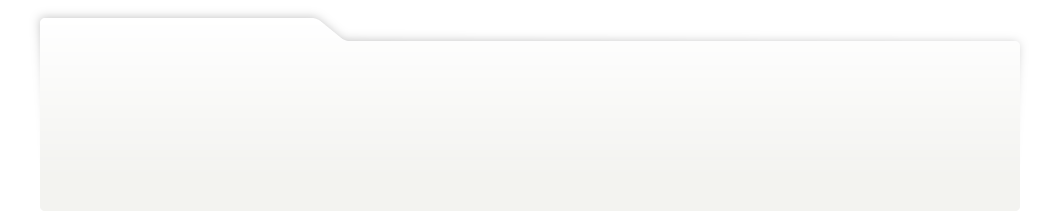
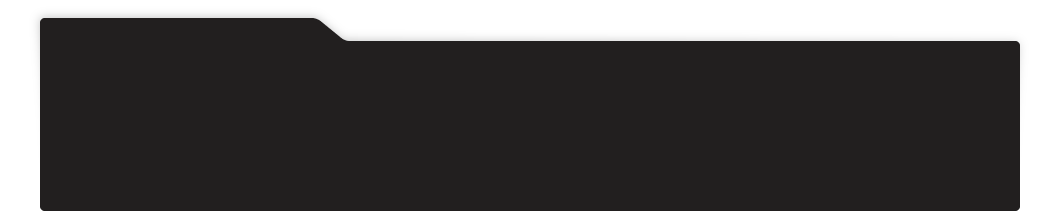
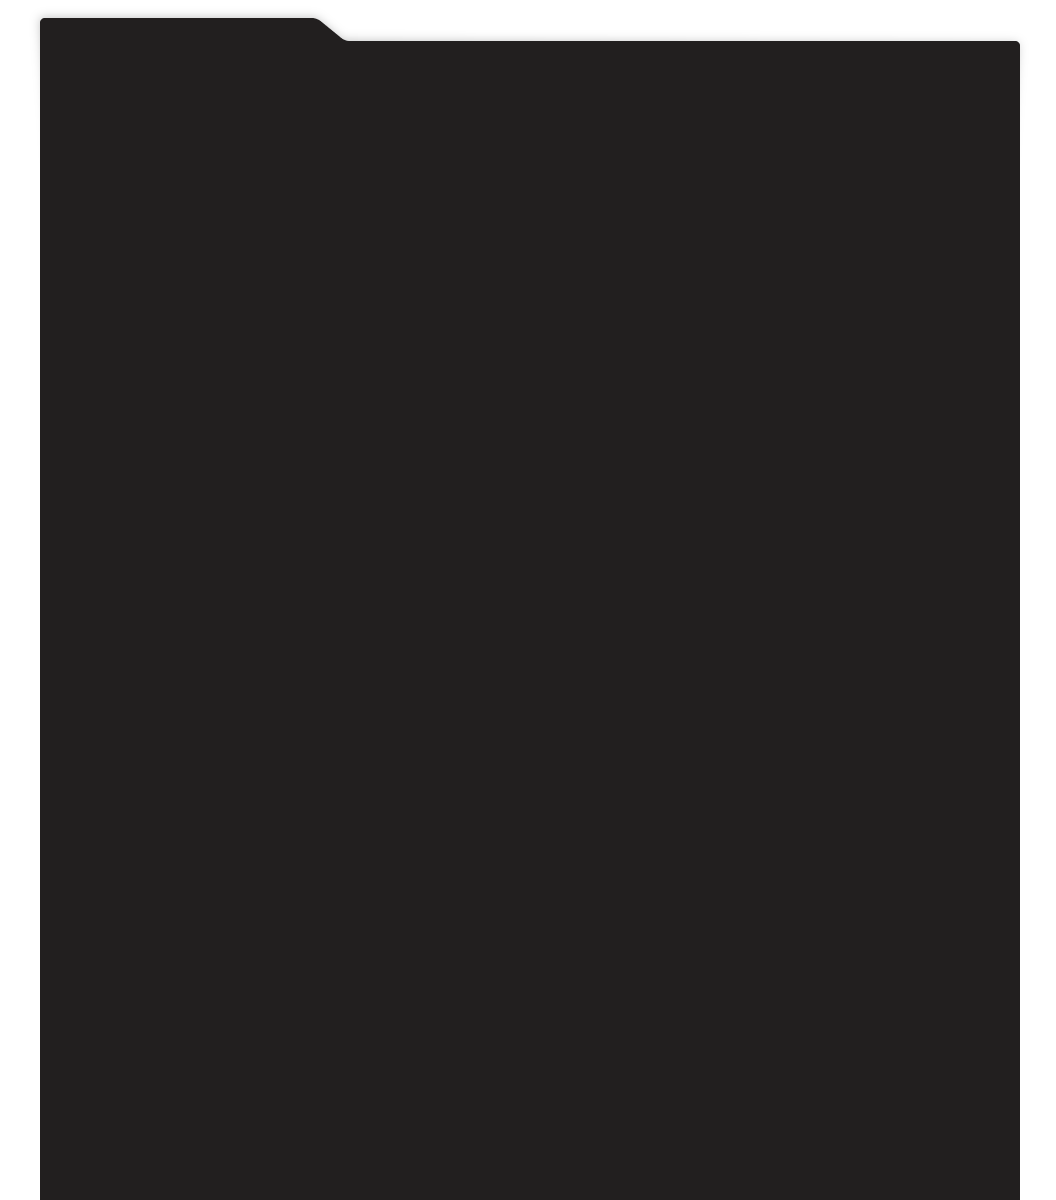
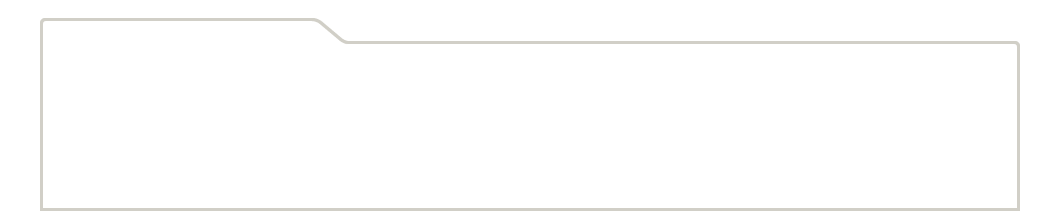
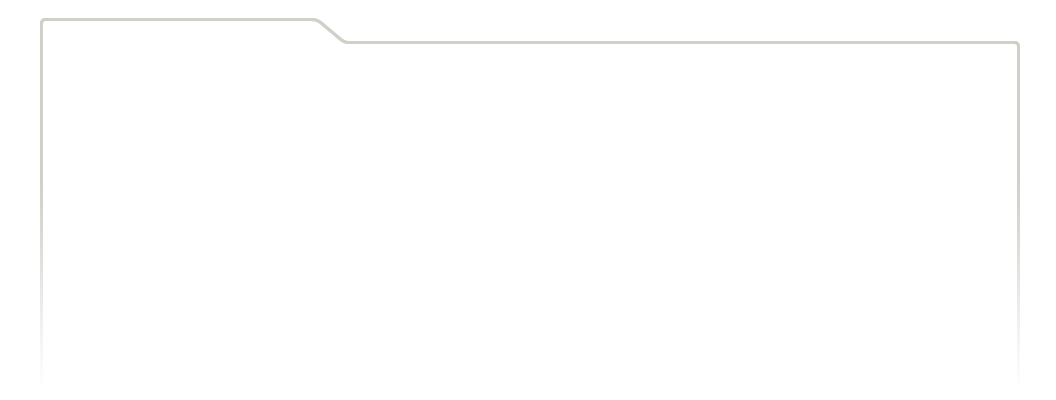
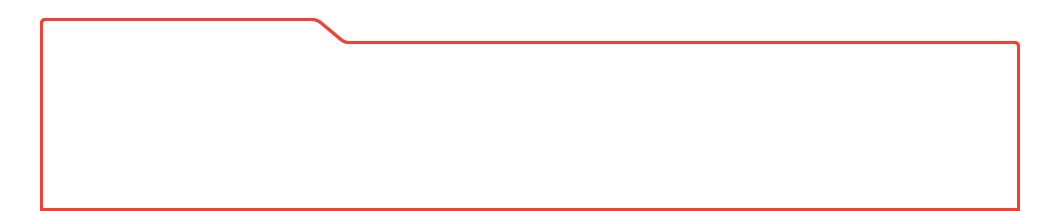
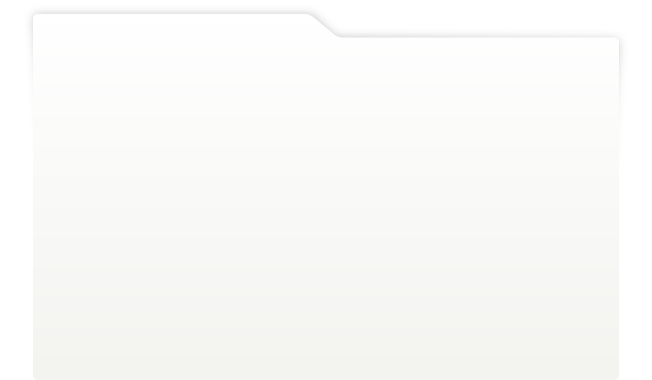
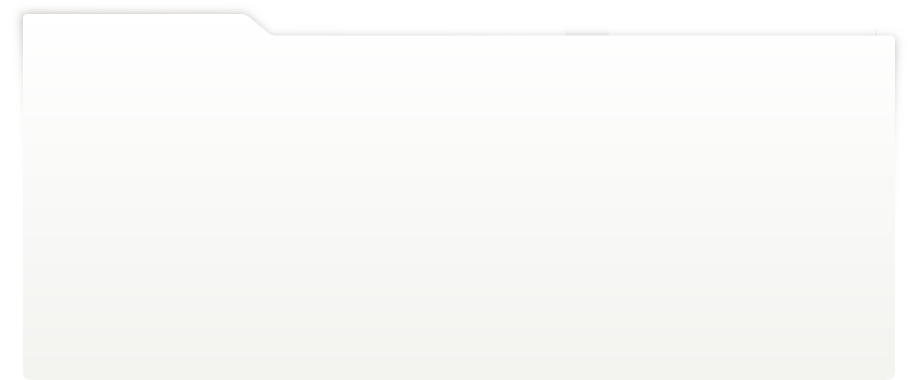
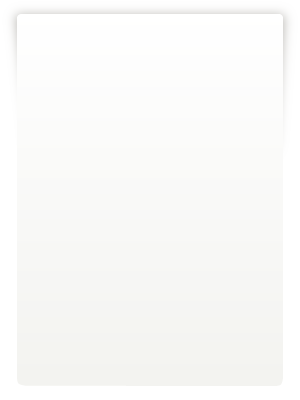
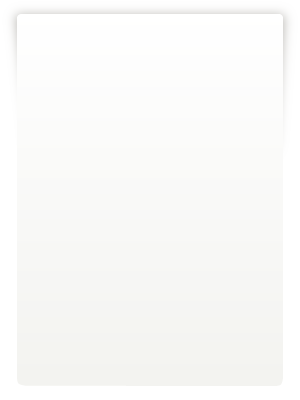
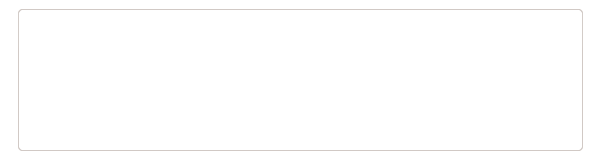
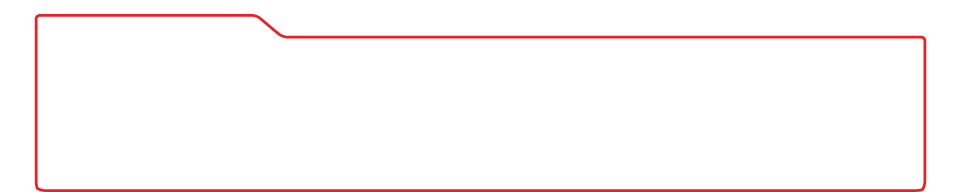
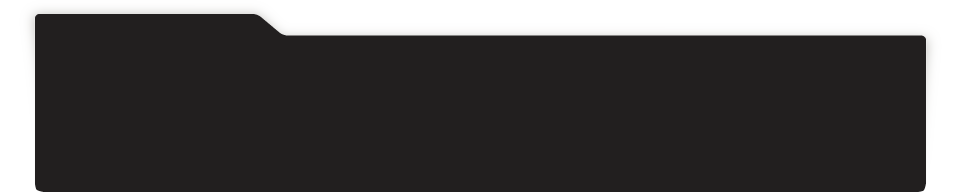
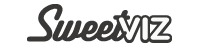
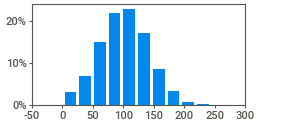
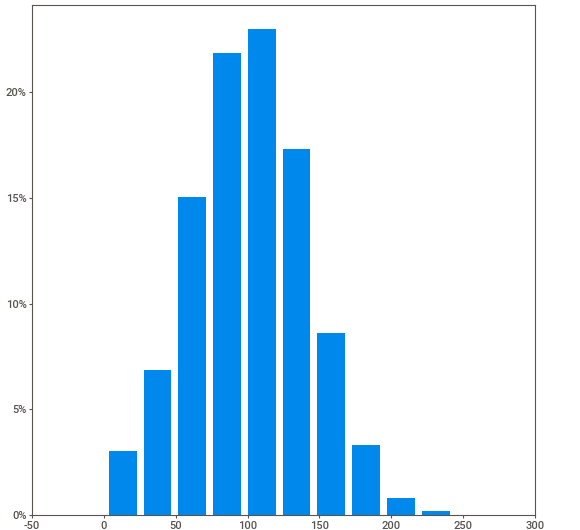
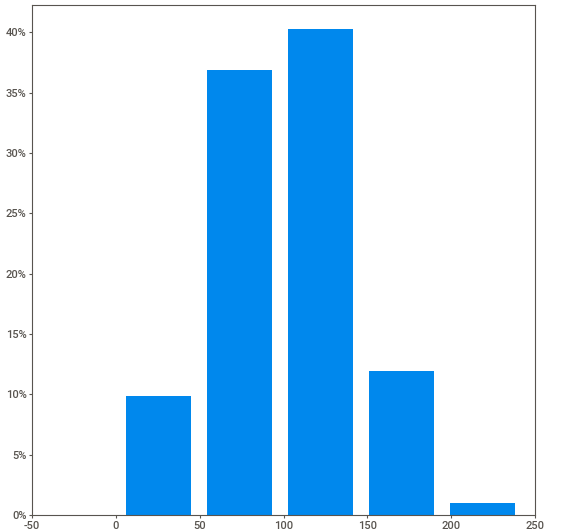
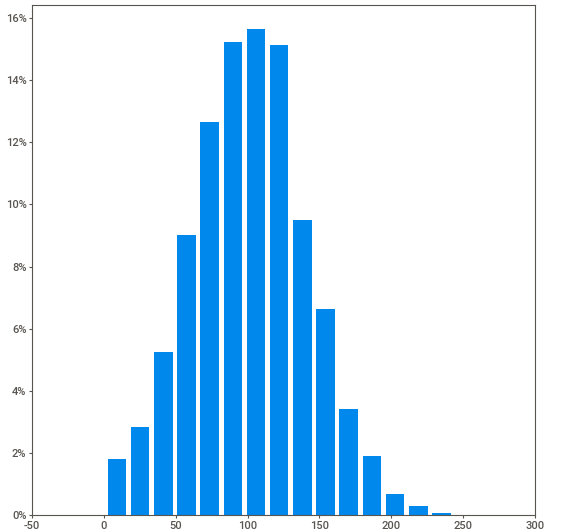
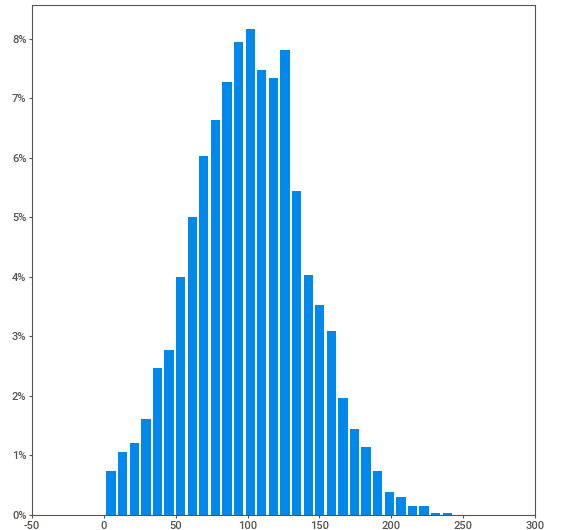
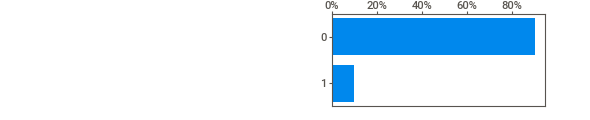
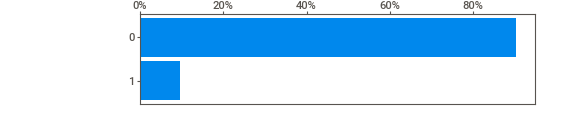
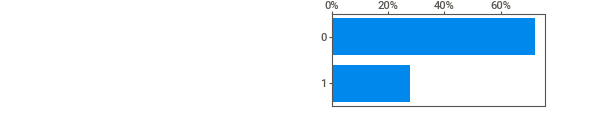
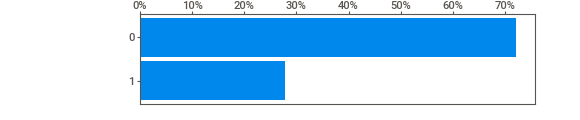
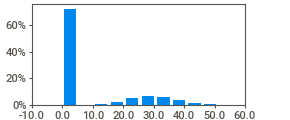
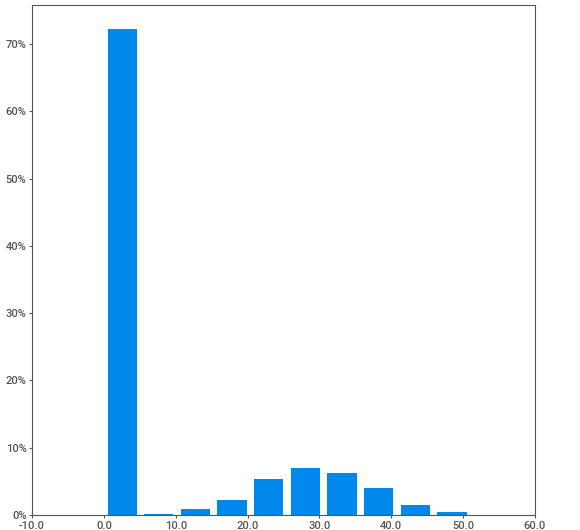
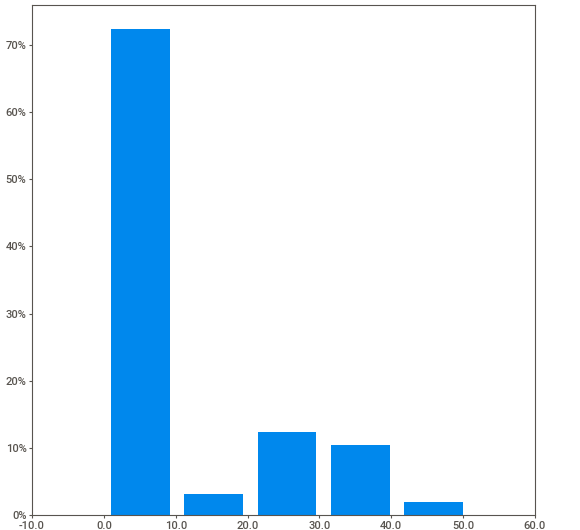
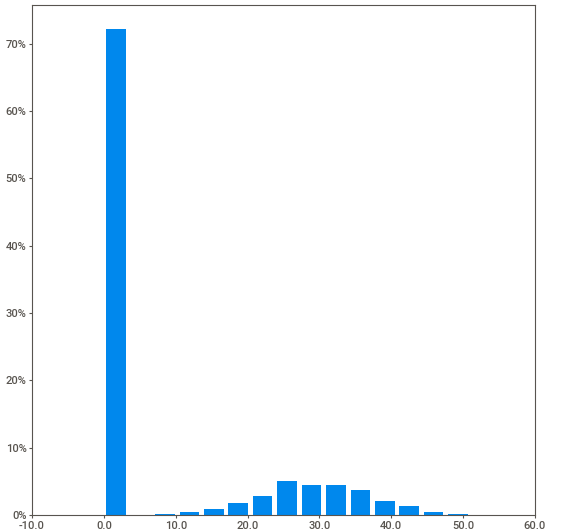
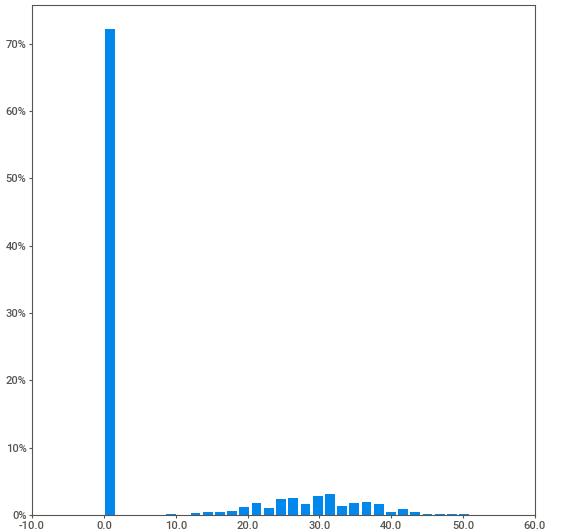
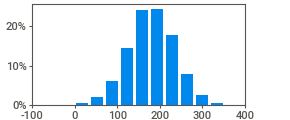
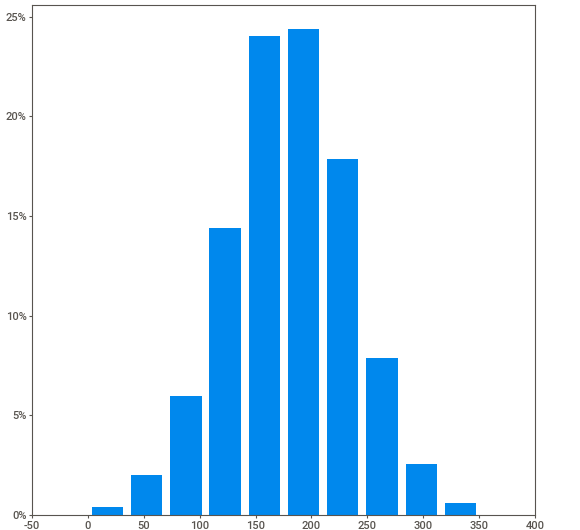
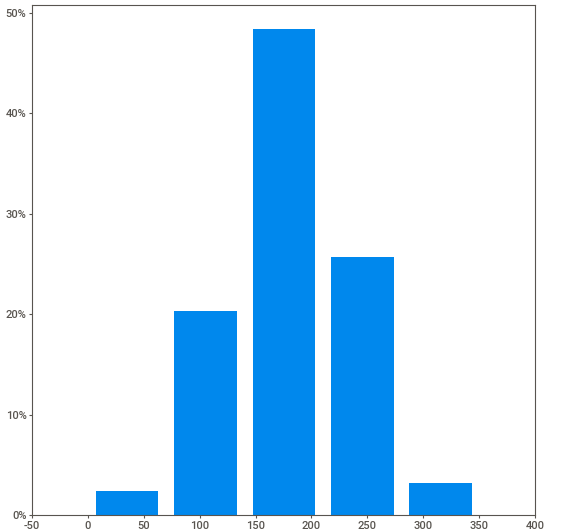
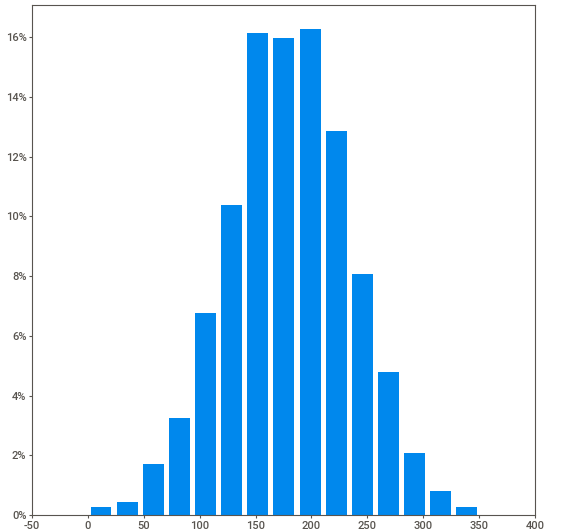
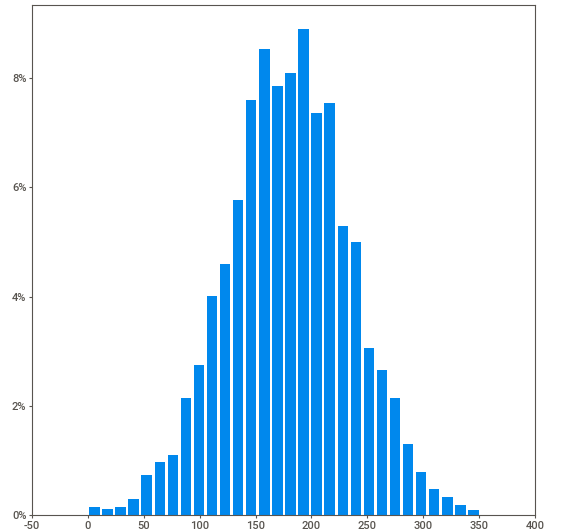
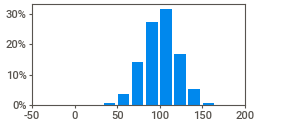
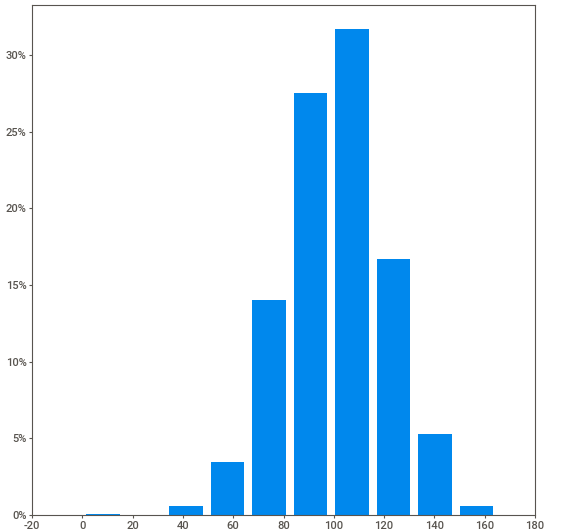
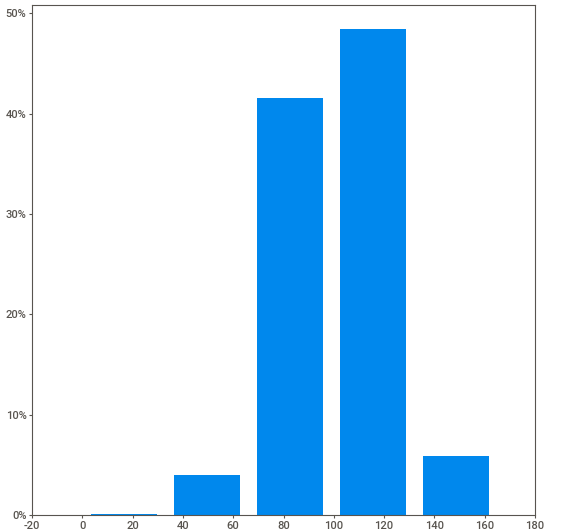
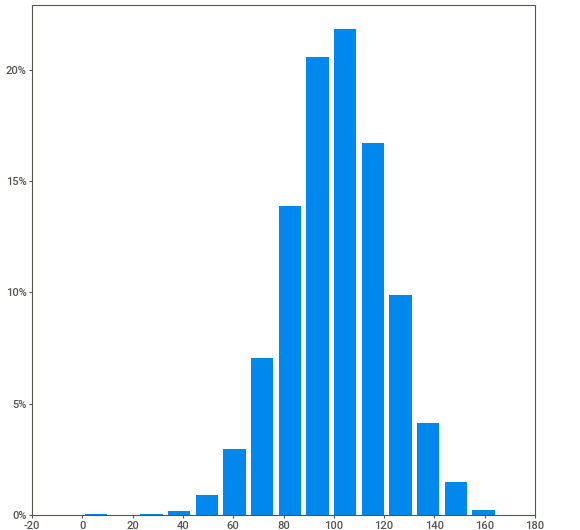
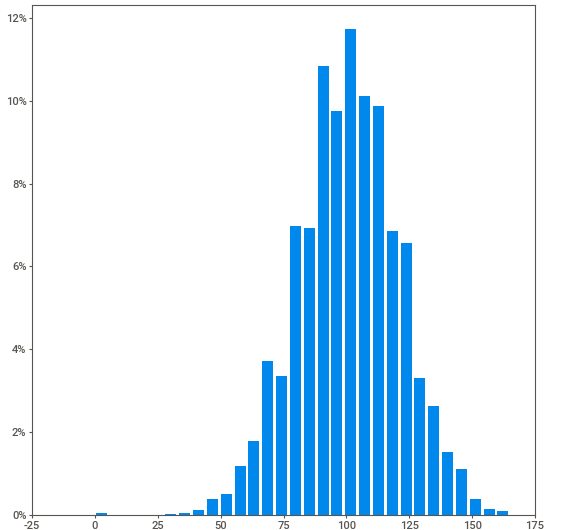
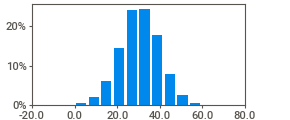
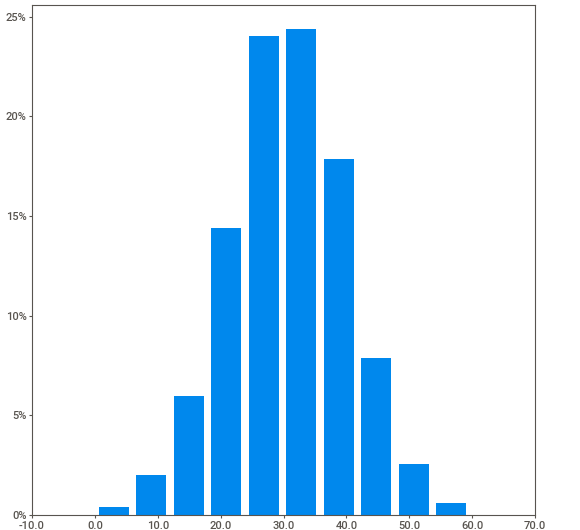
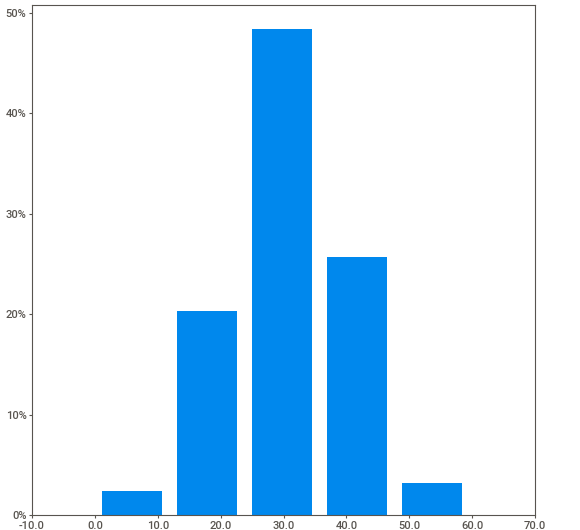
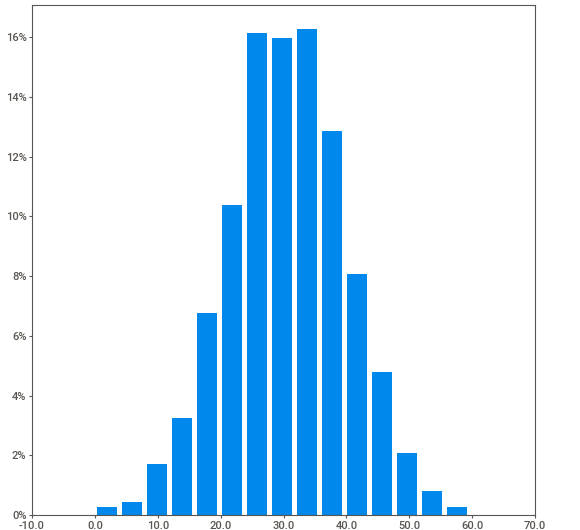
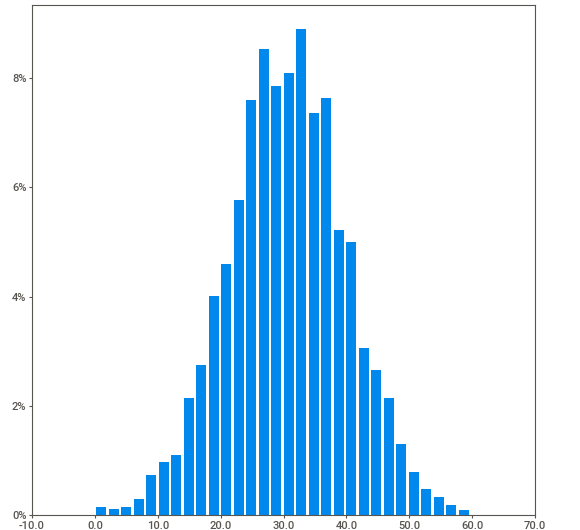
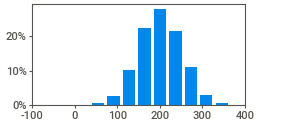
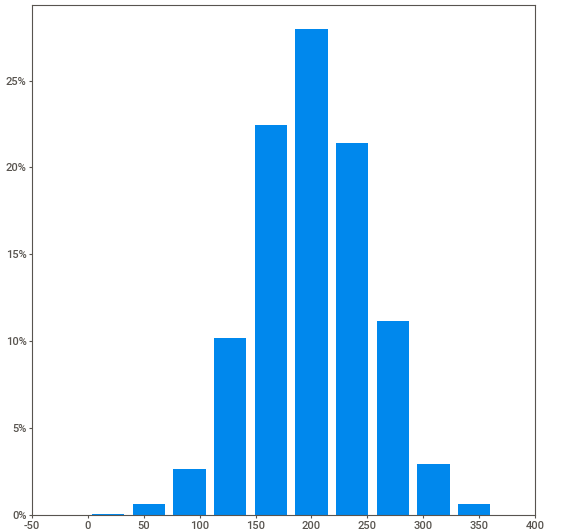
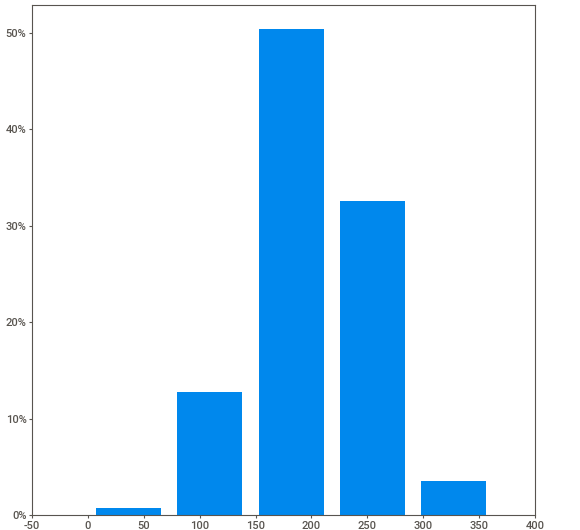
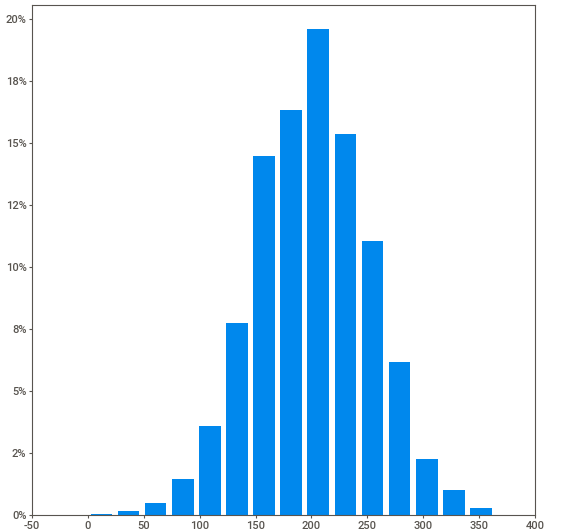
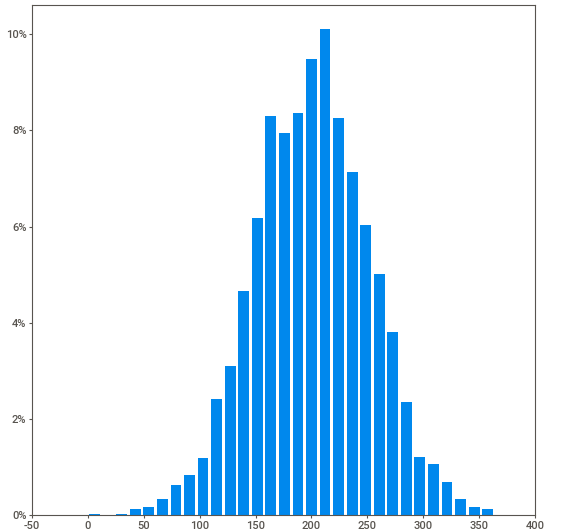
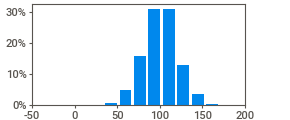
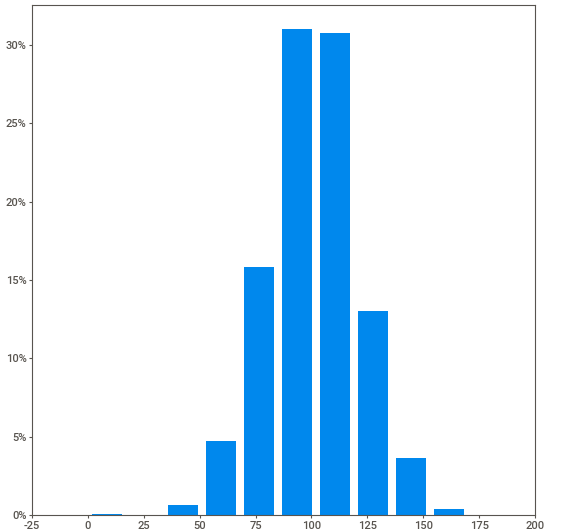
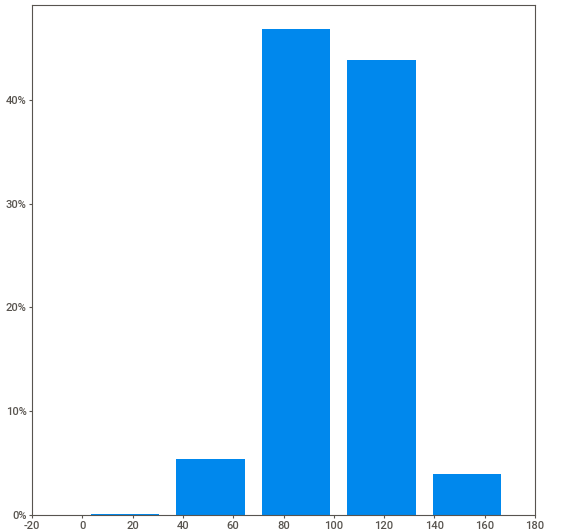
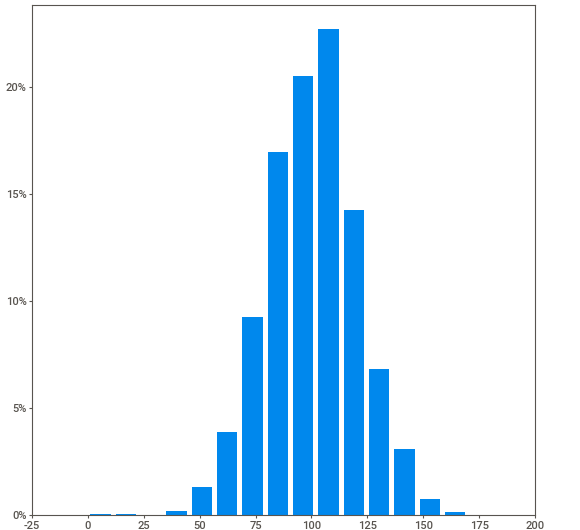
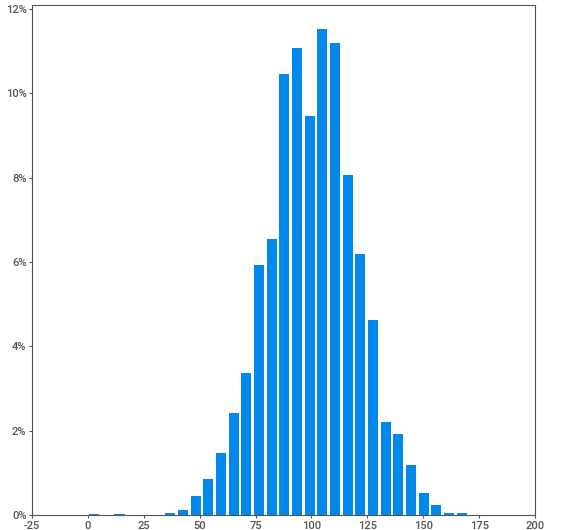
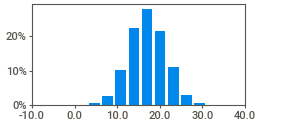
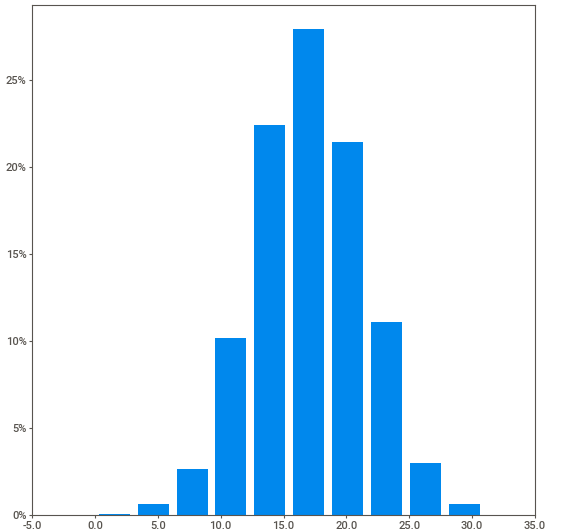
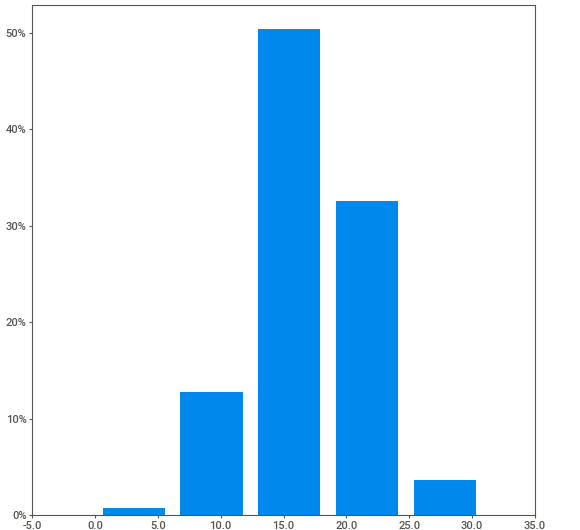
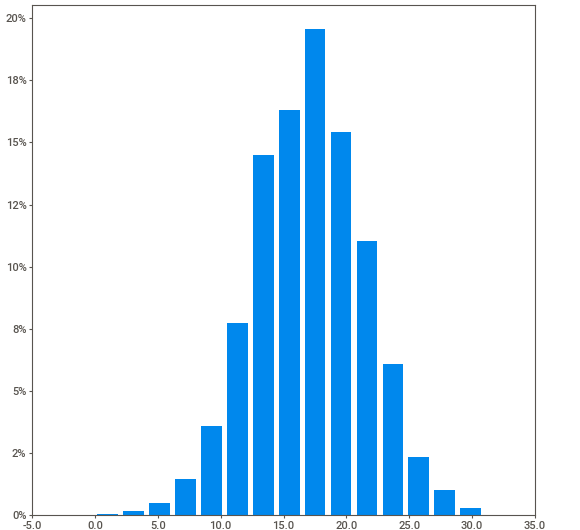
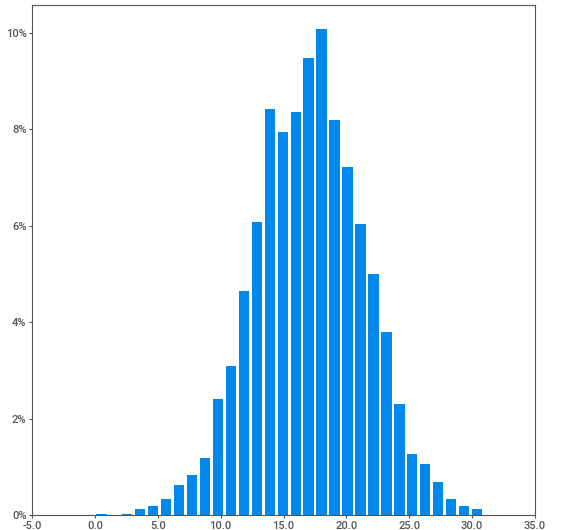
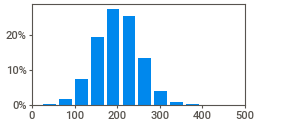
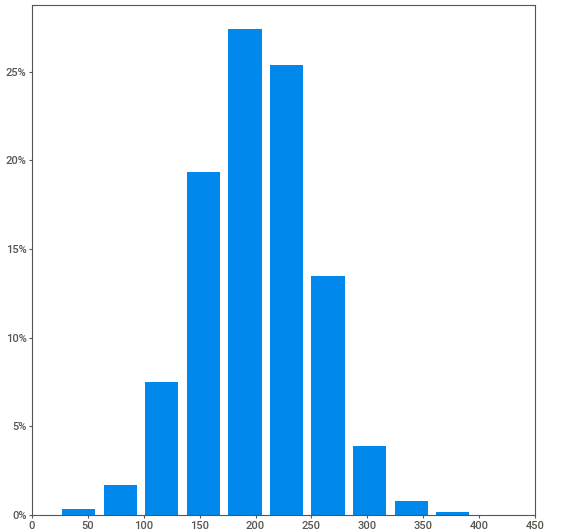
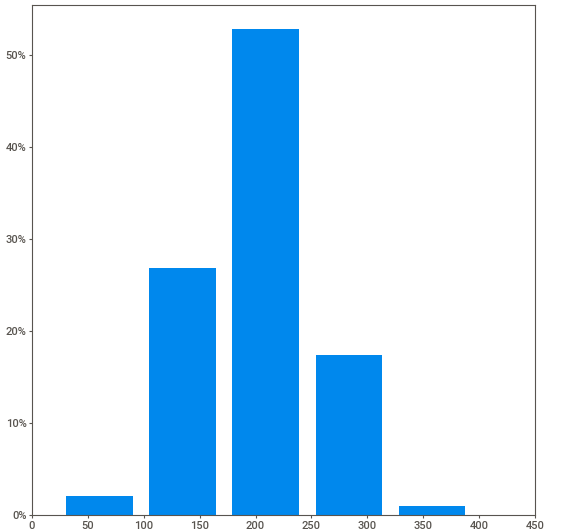
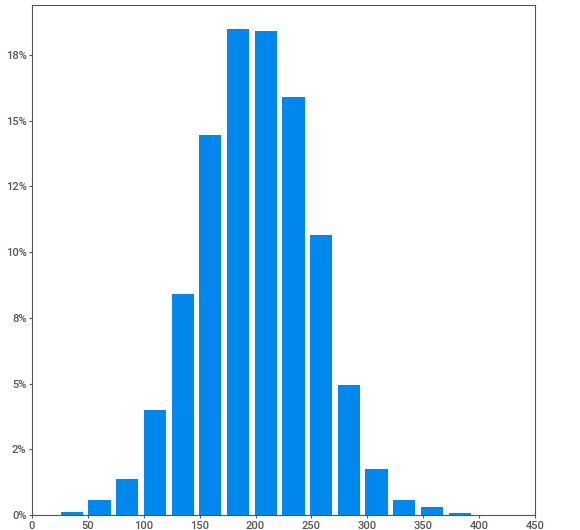
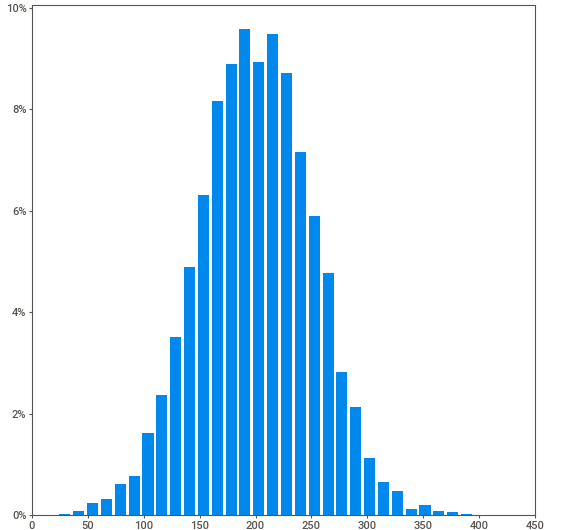
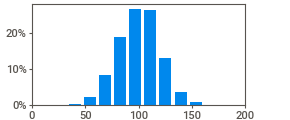
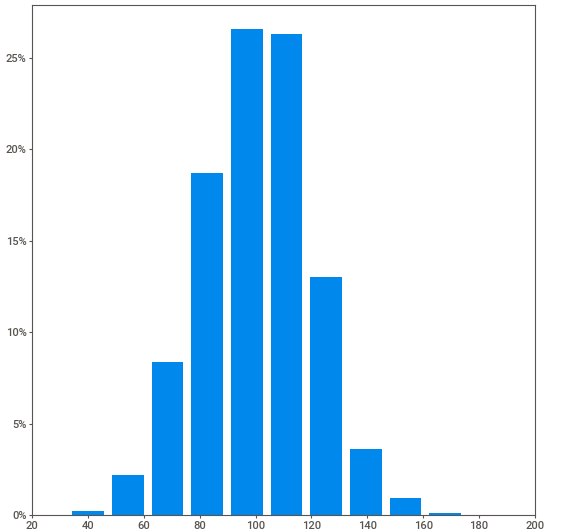
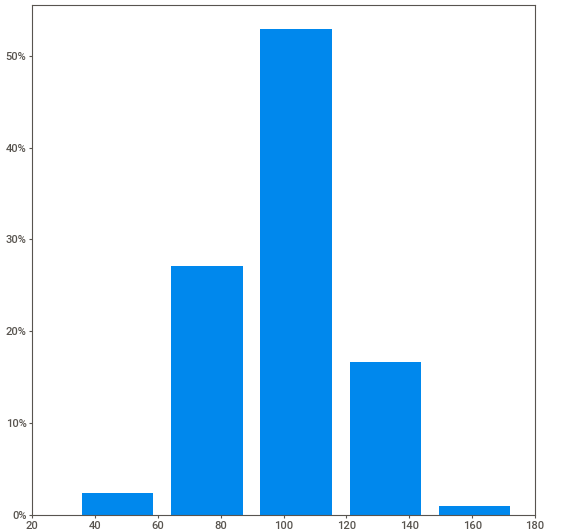
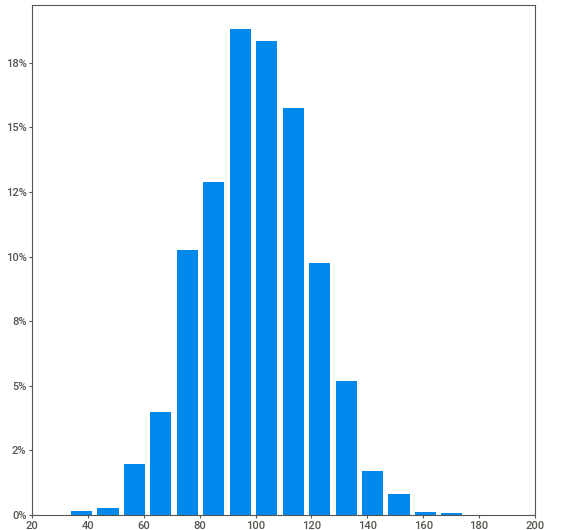
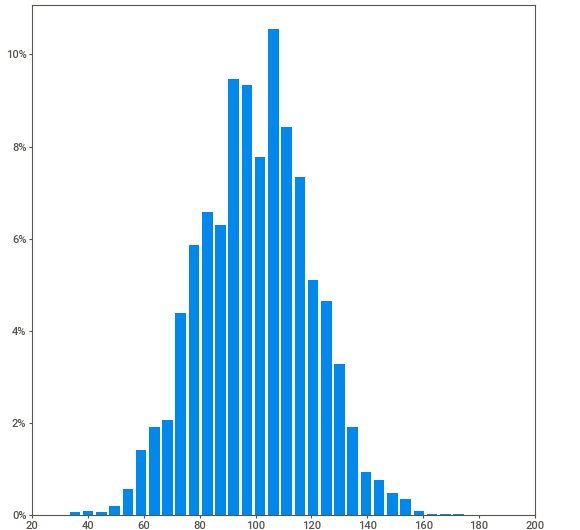
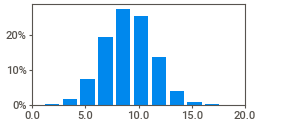
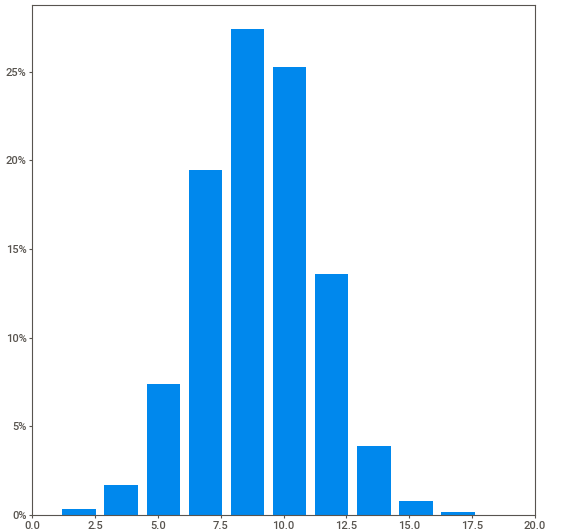
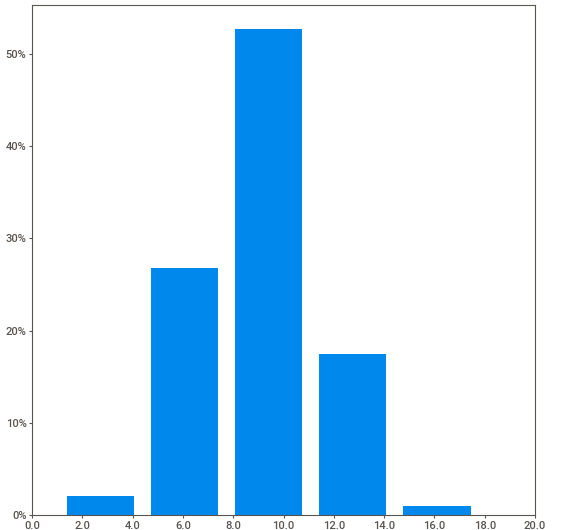
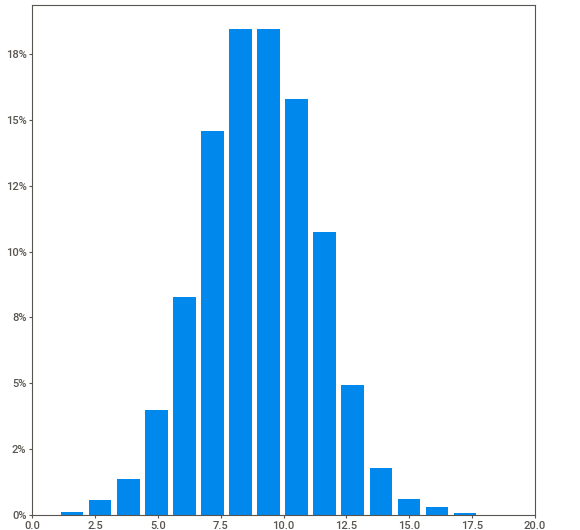
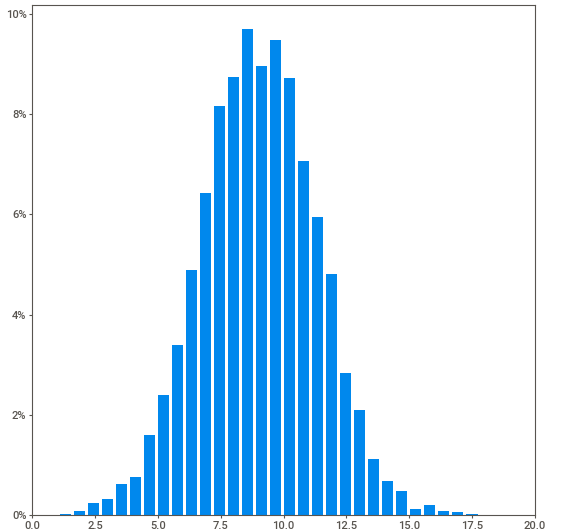
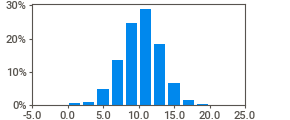
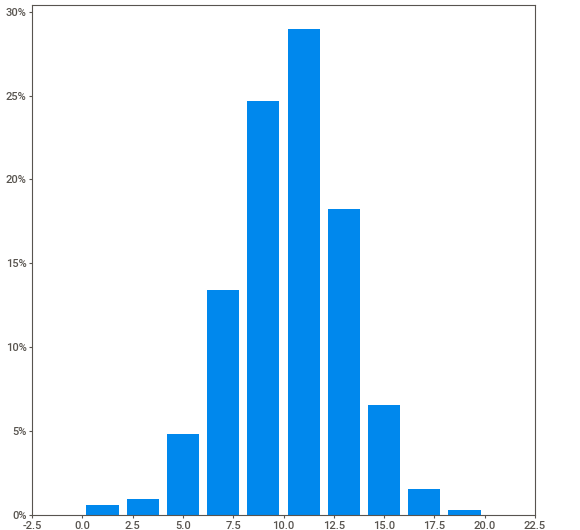
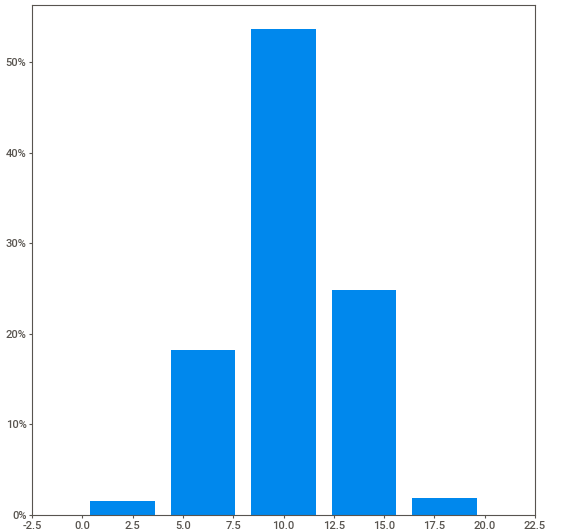
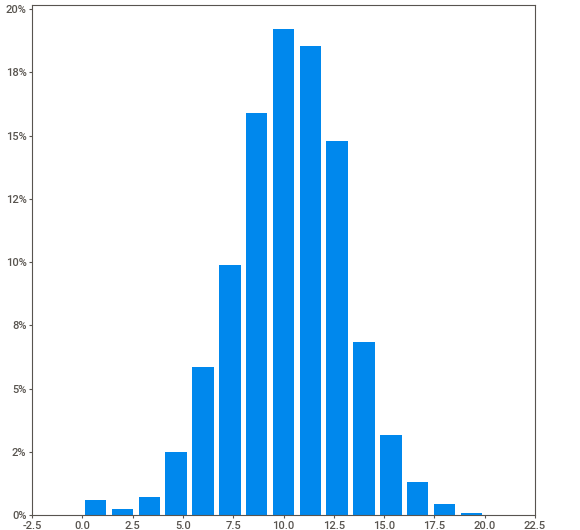
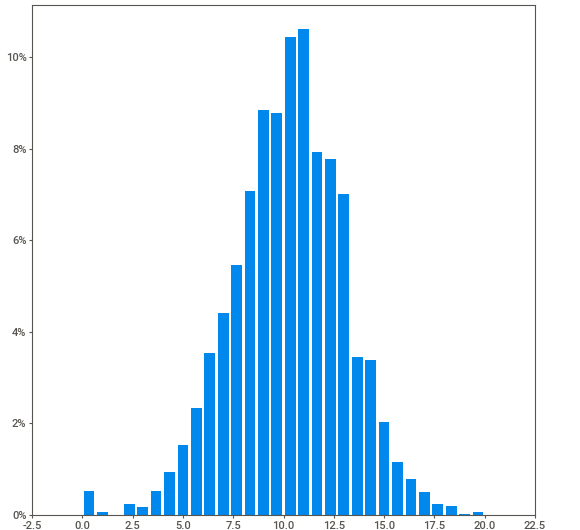
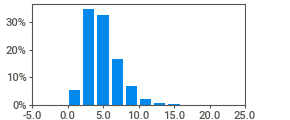
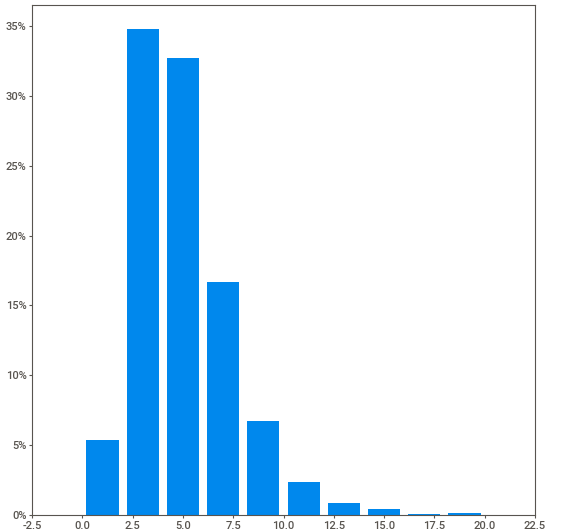
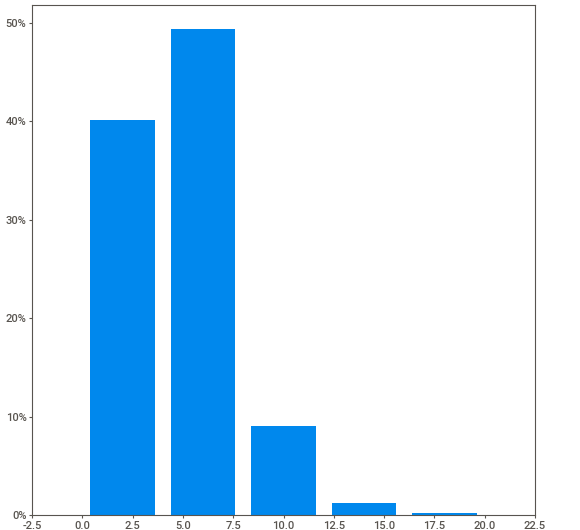
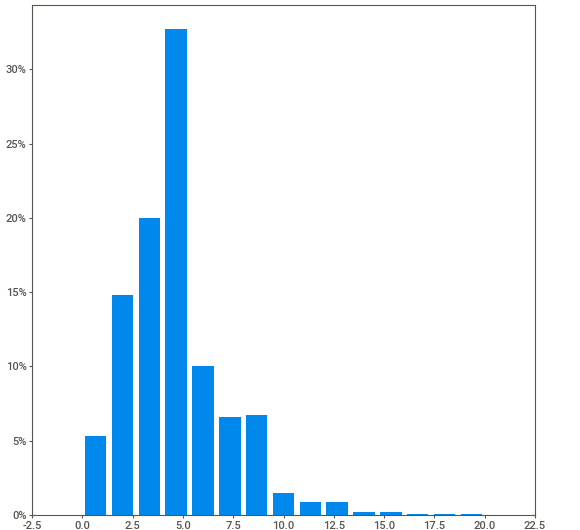
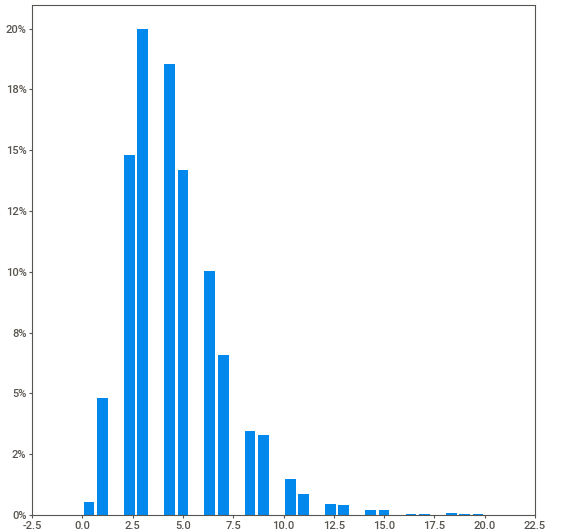
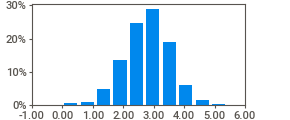
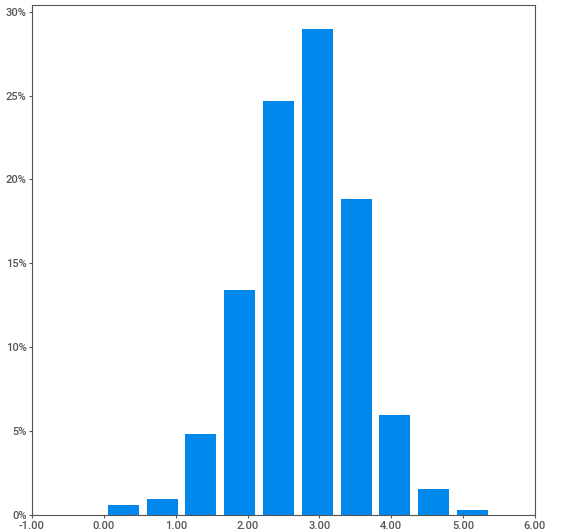
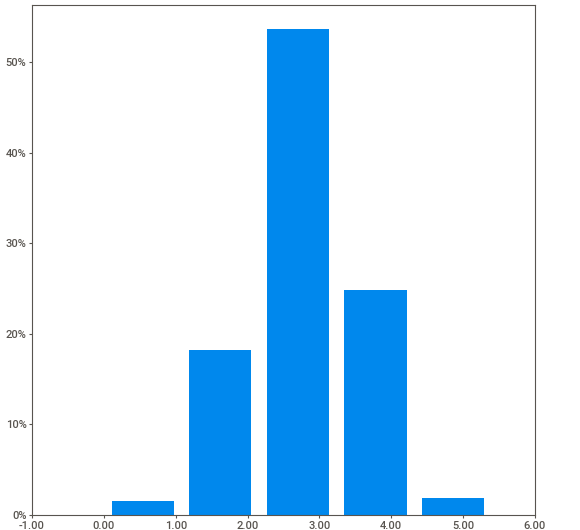
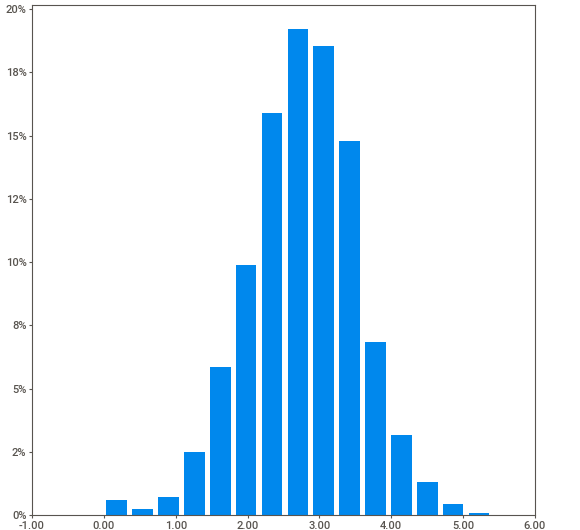
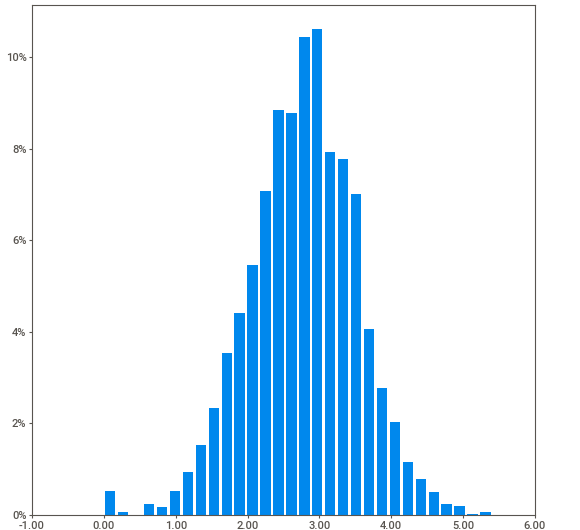
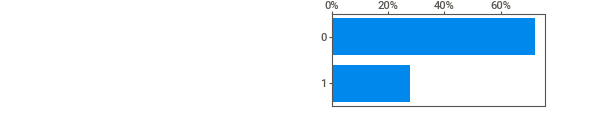
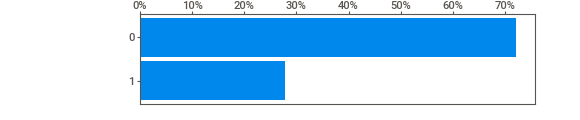
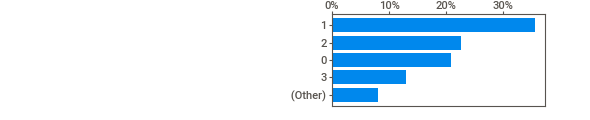
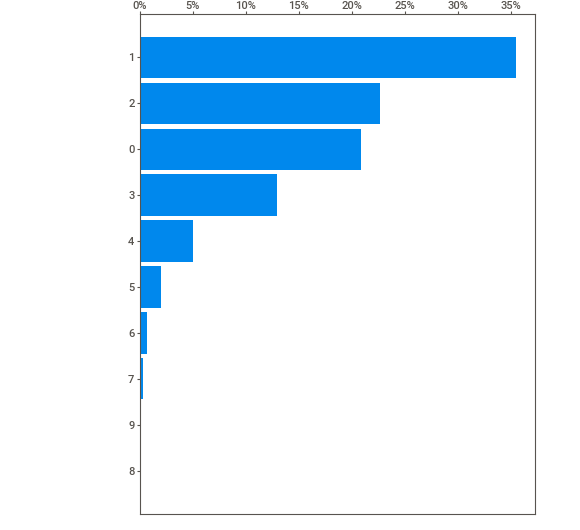
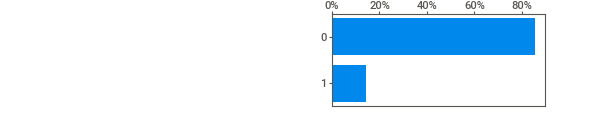
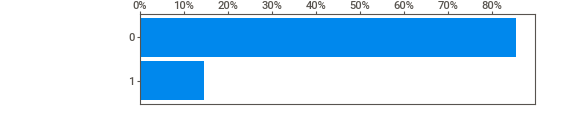
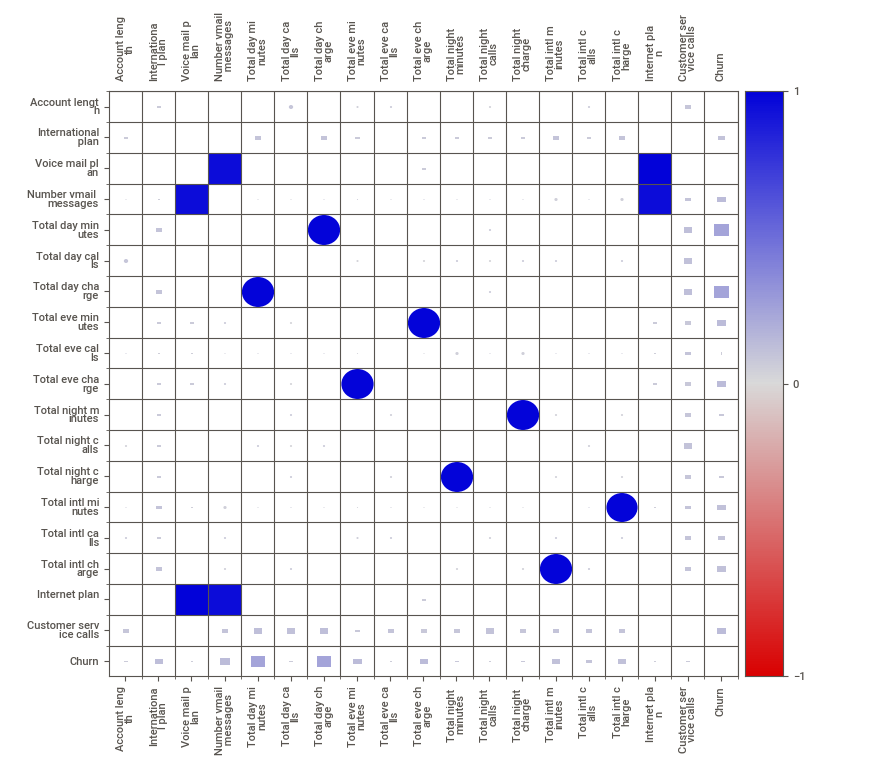
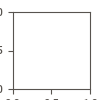

In [27]:
st_report = sv.analyze(df)
st_report.show_notebook()

Estandarizar

In [28]:
non_binary_columns = [col for col in df.columns if df[col].nunique()>2]
binary_columns = [col for col in df.columns if df[col].nunique()==2]

scaler = StandardScaler()
data_non_binary_scaled = scaler.fit_transform(df[non_binary_columns])
data_non_binary_scaled_df = pd.DataFrame(data_non_binary_scaled,columns=non_binary_columns)
df_binary = df[binary_columns].reset_index(drop=True)
df_scaled = pd.concat([df_binary,data_non_binary_scaled_df],axis=1)
df_scaled.head()

International plan  Voice mail plan  Internet plan  Churn  Account length  \
0                   0                1              1      0        0.677186   
1                   0                1              1      0        0.150388   
2                   0                0              0      0        0.902957   
3                   1                0              0      0       -0.426581   
4                   1                0              0      0       -0.652352   

   Number vmail messages  Total day minutes  Total day calls  \
0               1.228374           1.568850         0.478451   
1               1.301285          -0.334786         1.128149   
2              -0.594386           1.169730         0.678358   
3              -0.594386           2.199716        -1.470640   
4              -0.594386          -0.240983         0.628382   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0          1.569118          -0.067941        -0.055487         -0.067757   
1         -0.335060          -0.105452         0.145397         -0.104919   
2          1.169890          -1.572309         0.496944         -1.572825   
3          2.199877          -2.743030        -0.607918         -2.743433   
4         -0.240933          -1.037291         1.099596         -1.036296   

   Total night minutes  Total night calls  Total night charge  \
0             0.871421          -0.464584            0.870705   
1             1.063051           0.148838            1.063867   
2            -0.750520           0.199957           -0.749221   
3            -0.072901          -0.566821           -0.073154   
4            -0.270457           1.068972           -0.270706   

   Total intl minutes  Total intl calls  Total intl charge  \
0           -0.085763         -0.600639          -0.086434   
1            1.240481         -0.600639           1.241186   
2            0.702815          0.211617           0.696862   
3           -1.304473          1.023873          -1.307845   
4           -0.049918         -0.600639          -0.046606   

   Customer service calls  
0               -0.428962  
1               -0.428962  
2               -1.188653  
3                0.330728  
4                1.090419

Aquí ya tenemos el dataset listo para utilizarlo en nuestros modelos.

# Reduccion de la dimesionalidad

Harémos la matriz de correlación, para la identificación de variables y su selección

> Bloc con sangría



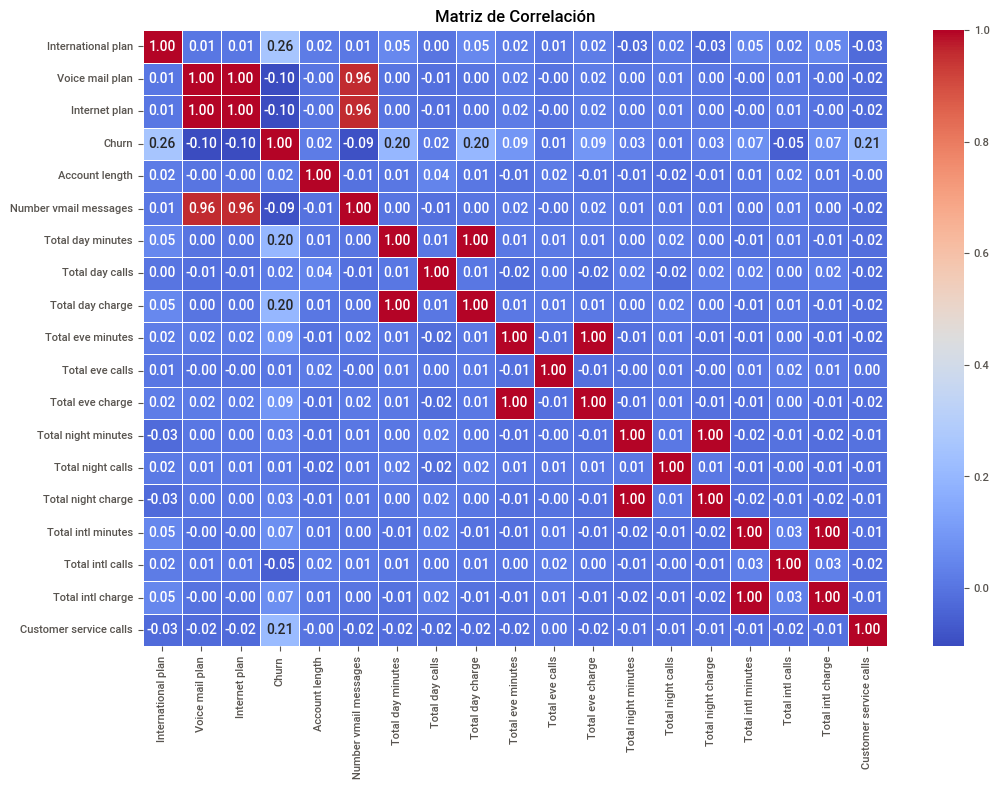

In [29]:
correlation_matrix = df_scaled.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matriz de Correlación')

plt.show()

In [30]:
df_scaled.columns

Index(['International plan', 'Voice mail plan', 'Internet plan', 'Churn',
       'Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls'],
      dtype='object')

Calculamos el coeficiente vif

In [31]:
dfvif = df_scaled.drop('Churn', axis=1)
dfvif.shape[1]

18

In [32]:
vif_estan = []
for i in range(dfvif.shape[1]):
    try:
        vif = variance_inflation_factor(dfvif.to_numpy(), i)
        vif_estan.append([dfvif.columns[i], vif])
    except Exception as e:
        vif_estan.append([dfvif.columns[i], np.inf])

df_vif_estan = pd.DataFrame(vif_estan, columns=['Variable', 'VIF'])

print(df_vif_estan)

                  Variable           VIF
0       International plan  1.092697e+00
1          Voice mail plan           inf
2            Internet plan           inf
3           Account length  1.003428e+00
4    Number vmail messages  3.110987e+00
5        Total day minutes  1.041300e+07
6          Total day calls  1.005044e+00
7         Total day charge  1.041301e+07
8        Total eve minutes  2.236259e+06
9          Total eve calls  1.002109e+00
10        Total eve charge  2.236260e+06
11     Total night minutes  6.398748e+05
12       Total night calls  1.002330e+00
13      Total night charge  6.398736e+05
14      Total intl minutes  6.908463e+04
15        Total intl calls  1.003112e+00
16       Total intl charge  6.908451e+04
17  Customer service calls  1.002669e+00


Observamos que hay variables altamente correlacionadas con otras, lo vimos en la matriz y en el VIF por lo que eliminaremos para quedar con menos variables que sean útiles para la solución de nuestro problema

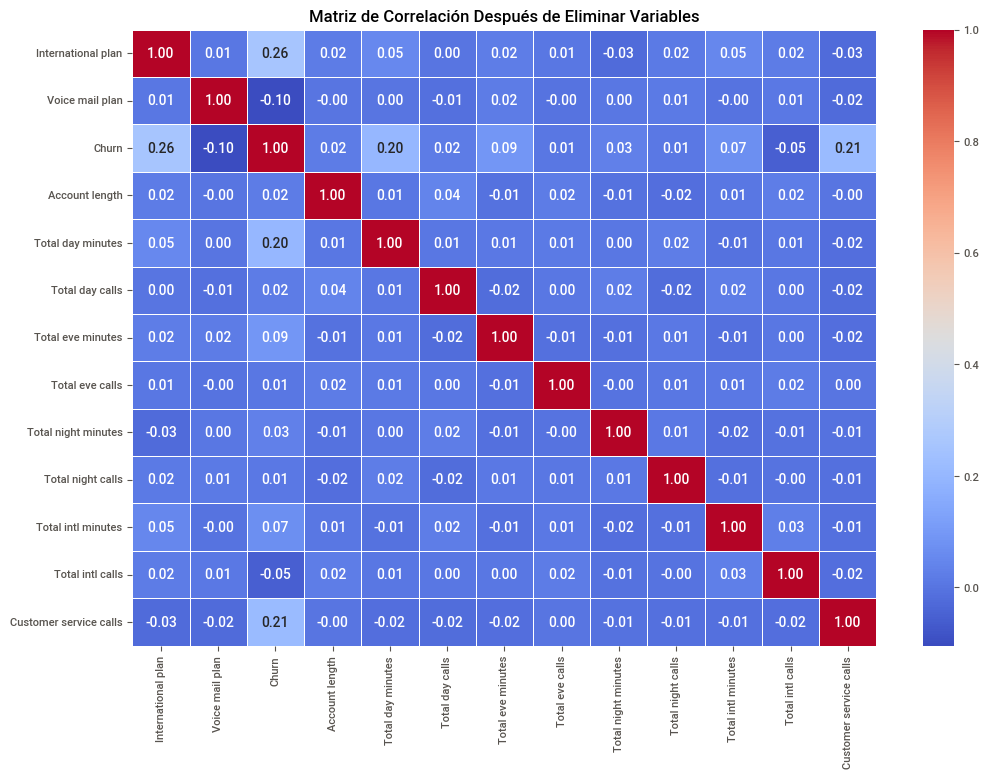

In [39]:
correlation_matrix = df_scaled.corr().abs()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

df_filtered = df_scaled.drop(to_drop, axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación Después de Eliminar Variables')
plt.show()

Luego estas son las columnas que utilizaremos para modelizar la tasa de abandono.

# Clusterizacion de los datos

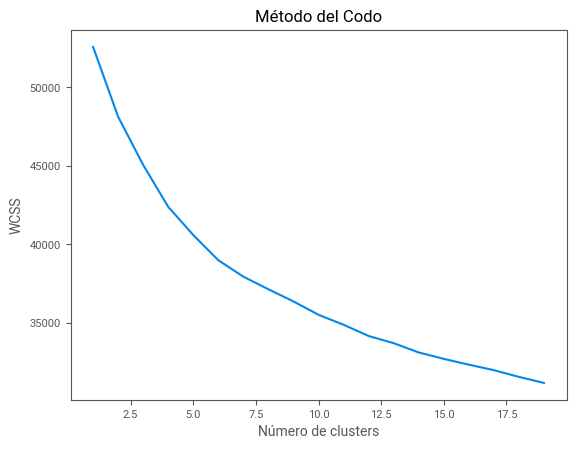

In [ ]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled.drop(['Churn'],axis=1))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

No es represantitivo aplicar el 'elbow method' ya que no se aprecia una diferencia significativa de ahorro en la función de coste SSE.

In [ ]:
Coste = []
krange = np.arange(2, 20)
for num in krange:
    X_numeric = df_scaled.drop(['Churn'],axis=1).select_dtypes(include=['float64', 'int64'])

    kmeans = KMeans(n_clusters=num, n_init='auto', random_state=10, max_iter=100).fit(X_numeric)
    print(
        "Para k =",
        num,
        ', el coste (SSE)=',
        kmeans.inertia_,
    )
    Coste.append(kmeans.inertia_)

Para k = 2 , el coste (SSE)= 48213.30846303407
Para k = 3 , el coste (SSE)= 45084.5531313004
Para k = 4 , el coste (SSE)= 42829.61407663999
Para k = 5 , el coste (SSE)= 41128.50999954005
Para k = 6 , el coste (SSE)= 39028.00089672394
Para k = 7 , el coste (SSE)= 38127.653623027385
Para k = 8 , el coste (SSE)= 37131.82051479637
Para k = 9 , el coste (SSE)= 36389.00123320666
Para k = 10 , el coste (SSE)= 35589.031670707394
Para k = 11 , el coste (SSE)= 35107.12513545685
Para k = 12 , el coste (SSE)= 34373.7053167961
Para k = 13 , el coste (SSE)= 34042.625403440325
Para k = 14 , el coste (SSE)= 33550.84457071142
Para k = 15 , el coste (SSE)= 32746.682076136178
Para k = 16 , el coste (SSE)= 32486.97493112208
Para k = 17 , el coste (SSE)= 31987.090817352684
Para k = 18 , el coste (SSE)= 31733.384166152056
Para k = 19 , el coste (SSE)= 31289.46898558715


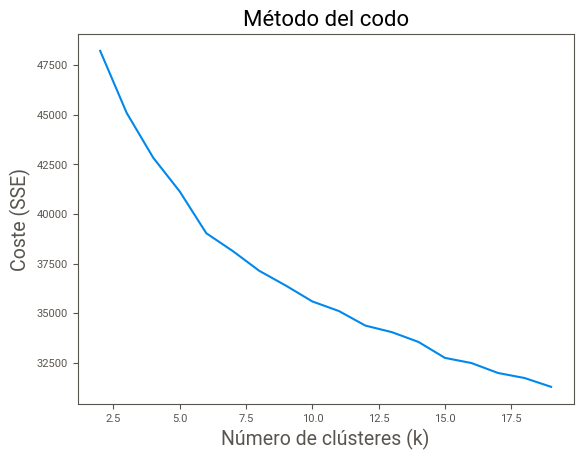

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Método del codo', fontsize = 16)
ax.set_ylabel("Coste (SSE)",fontsize=14)
ax.set_xlabel("Número de clústeres (k)", fontsize=14)
ax.plot(krange,Coste)
plt.show()

In [ ]:
Calinski = []
krange = np.arange(2, 11)

for num in krange:
    kmeans = KMeans(n_clusters=num, n_init='auto', random_state=10, max_iter=100)
    Y_pred = kmeans.fit_predict(df_scaled.drop(['Churn'], axis=1))
    CH_score = calinski_harabasz_score(df_scaled.drop(['Churn'], axis=1), Y_pred)
    print("Para k =", num, ', CH =', CH_score)
    Calinski.append(CH_score)

Para k = 2 , CH = 307.68260831784534
Para k = 3 , CH = 282.16287911388656
Para k = 4 , CH = 257.4654569120687
Para k = 5 , CH = 236.07991183400293
Para k = 6 , CH = 235.44861911403086
Para k = 7 , CH = 214.11521241020458
Para k = 8 , CH = 201.37019316648022
Para k = 9 , CH = 188.38256035031986
Para k = 10 , CH = 179.61878143076802


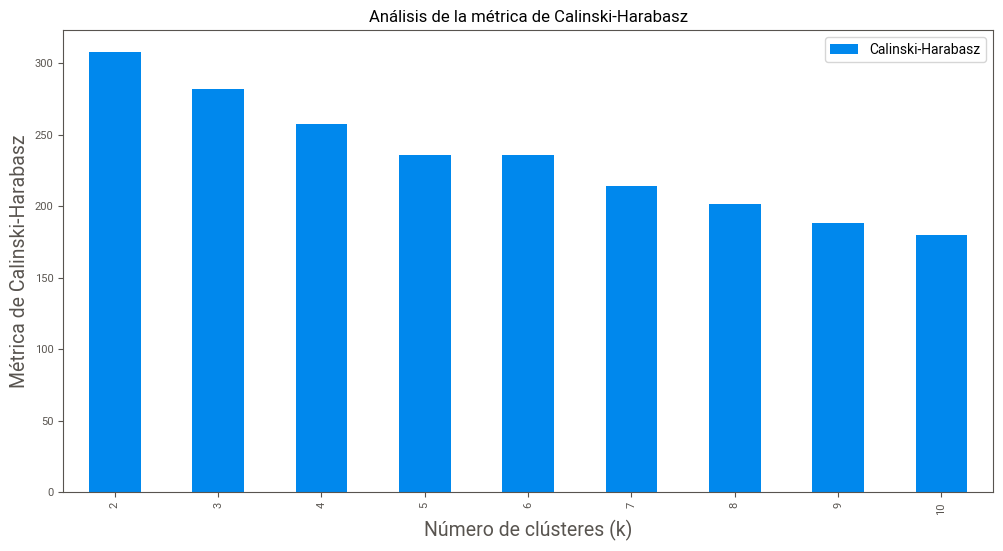

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=False)
pd.DataFrame({'n_clusters': krange,'Calinski-Harabasz': Calinski,}).set_index('n_clusters').plot(title='Análisis de la métrica de Calinski-Harabasz',
kind='bar',ax=ax)
ax.set_ylabel("Métrica de Calinski-Harabasz",fontsize=14)
ax.set_xlabel("Número de clústeres (k)", fontsize=14)
plt.show()

In [ ]:
X = df_scaled.drop(['Churn'],axis=1)

Para k = 2 , S = 0.08018835425195886
Para k = 3 , S = 0.07508879682685489
Para k = 4 , S = 0.07283750669044127
Para k = 5 , S = 0.0707197189105976
Para k = 6 , S = 0.07650753997171234
Para k = 7 , S = 0.07590178132638296
Para k = 8 , S = 0.07134992514165885
Para k = 9 , S = 0.06867088609131373
Para k = 10 , S = 0.07069188719714713
Para k = 11 , S = 0.06670379104636055
Para k = 12 , S = 0.07012658983525508
Para k = 13 , S = 0.06812061348202099
Para k = 14 , S = 0.06678661690485606
Para k = 15 , S = 0.06966221165192515
Para k = 16 , S = 0.06775822430536842
Para k = 17 , S = 0.0686178657358668
Para k = 18 , S = 0.06763333880721153
Para k = 19 , S = 0.07026219591081416


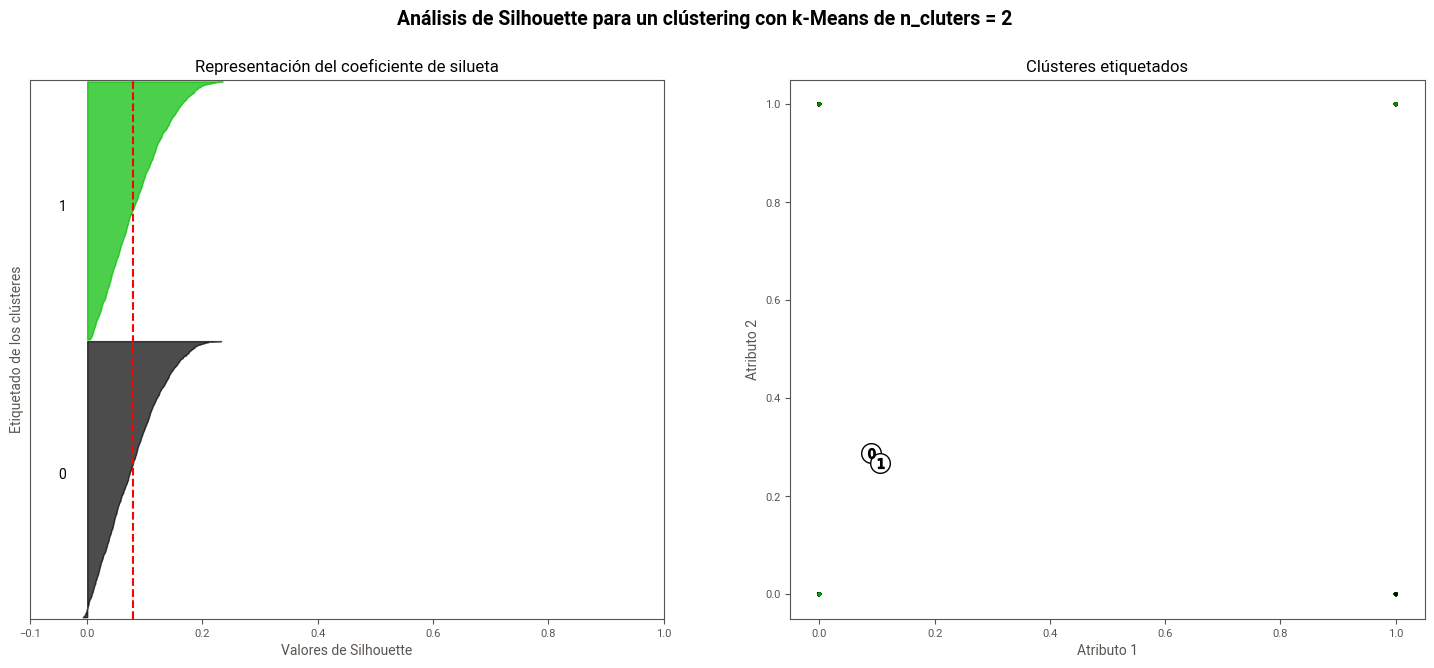

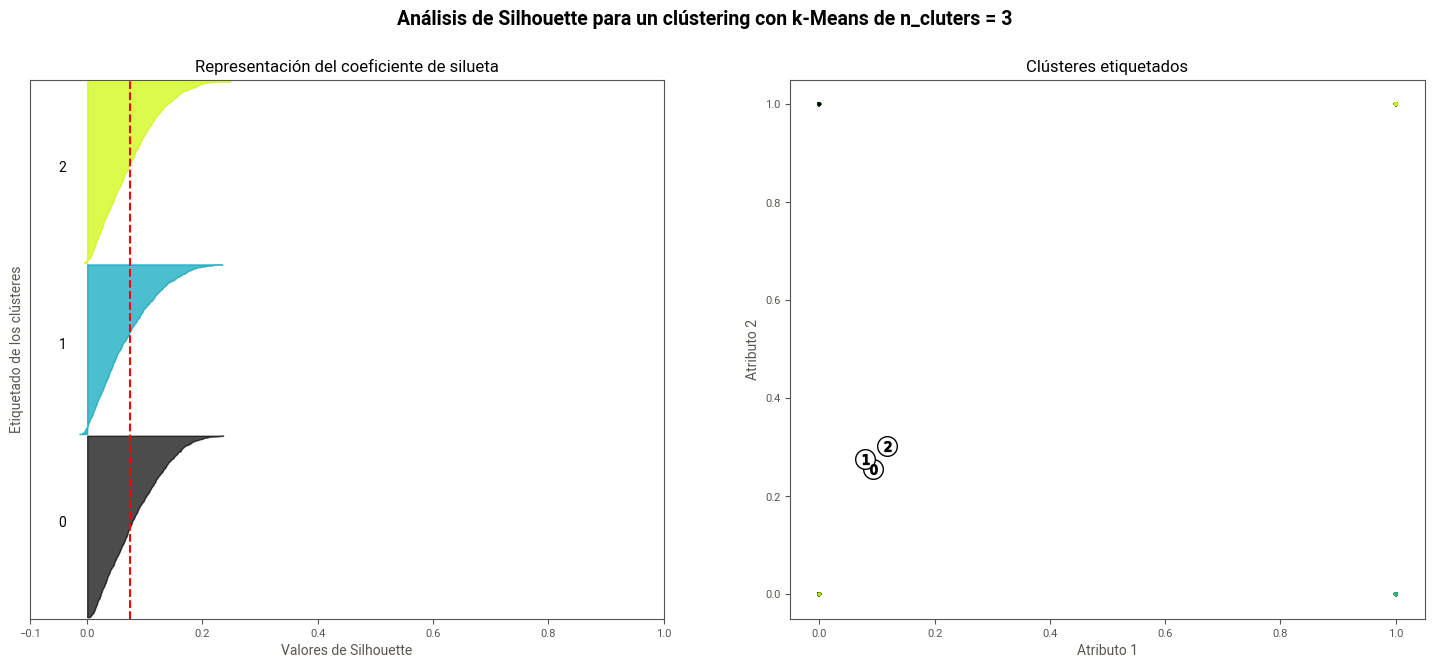

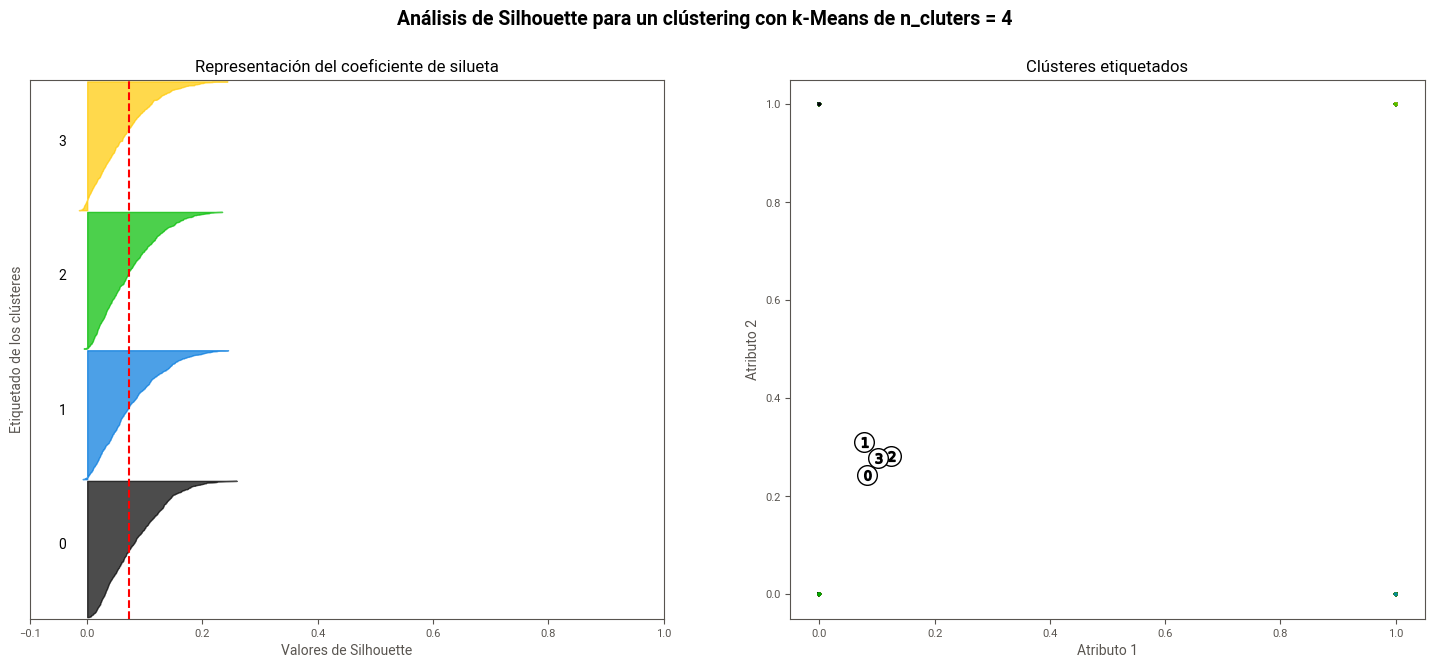

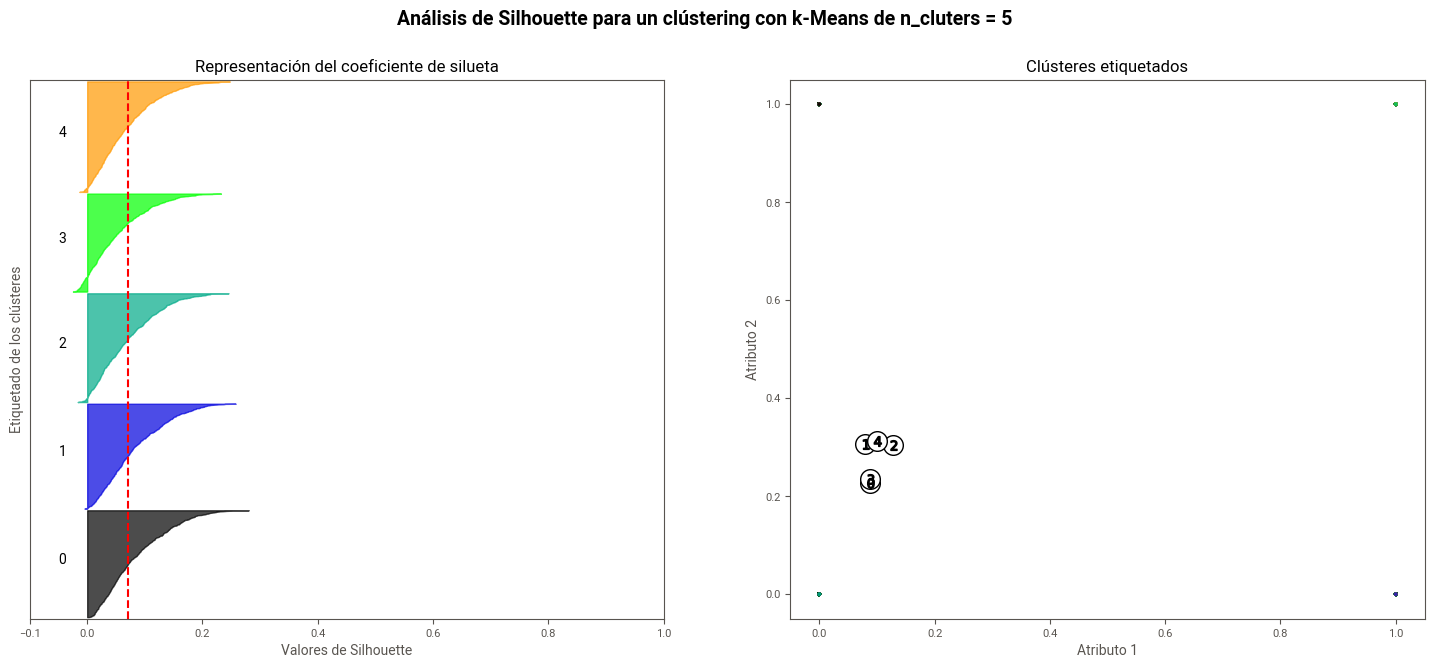

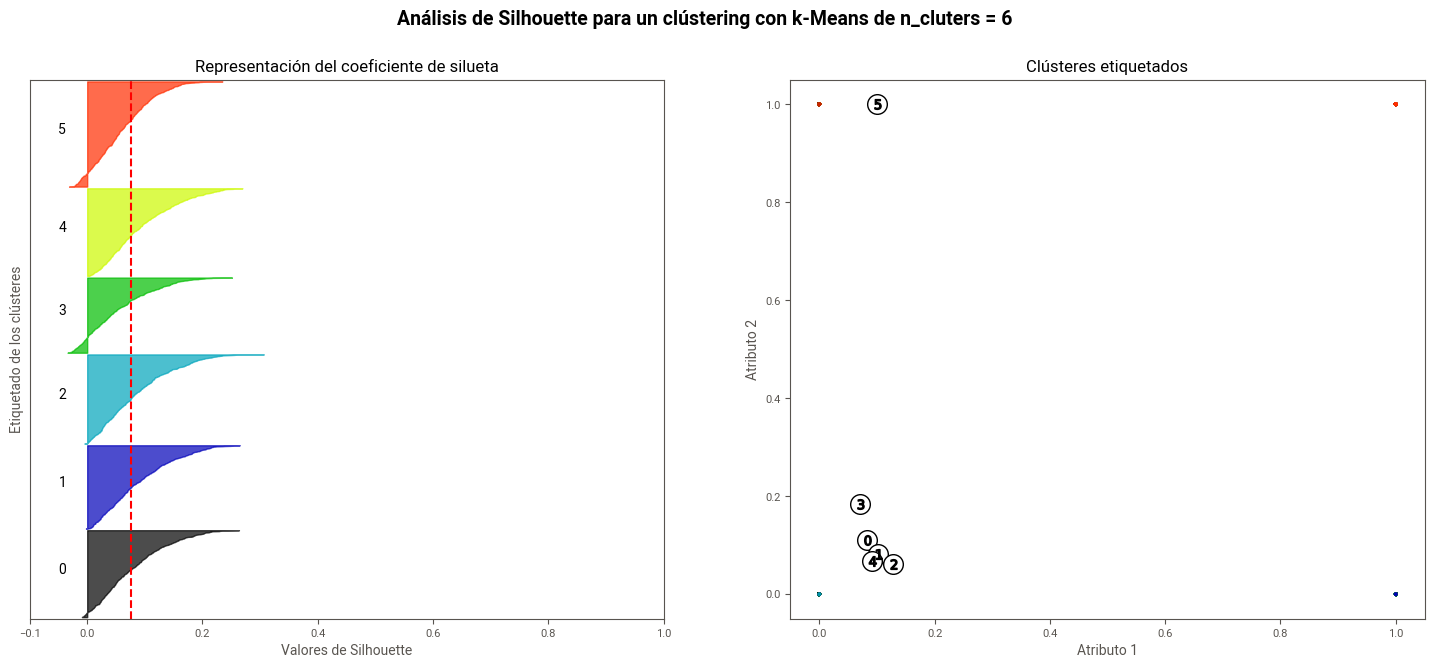

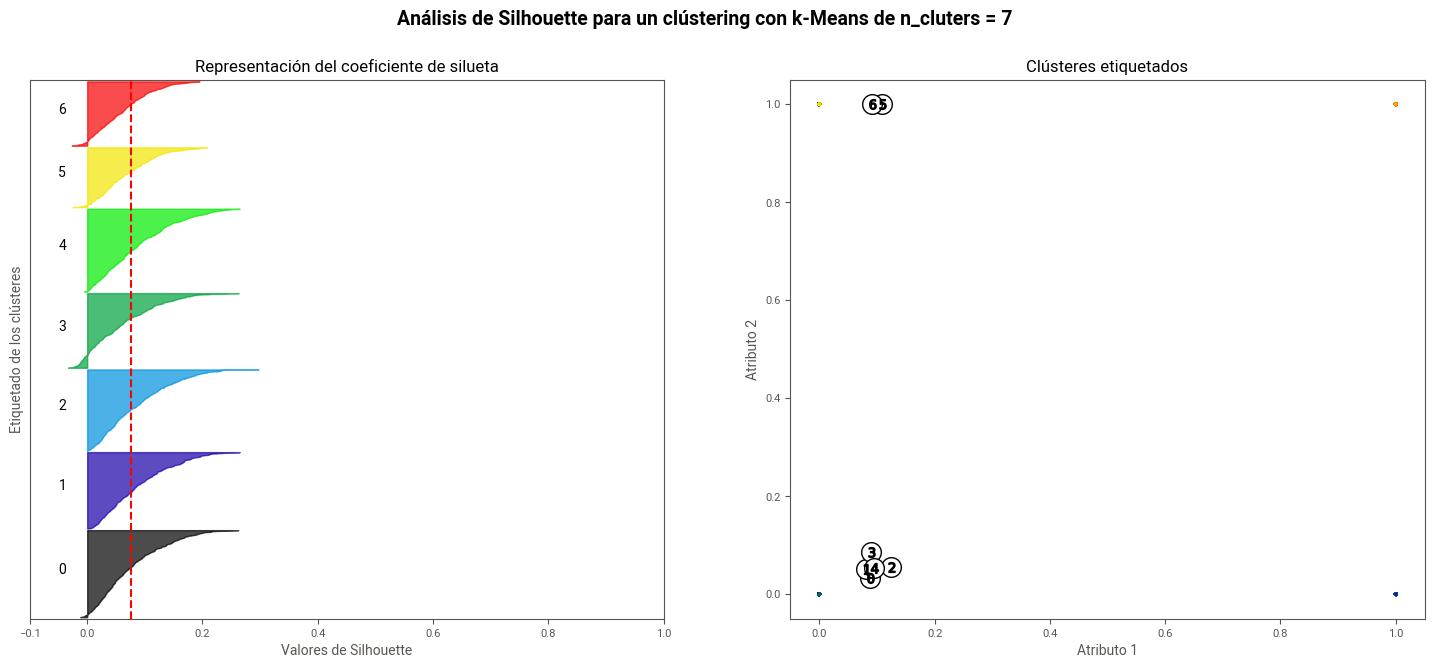

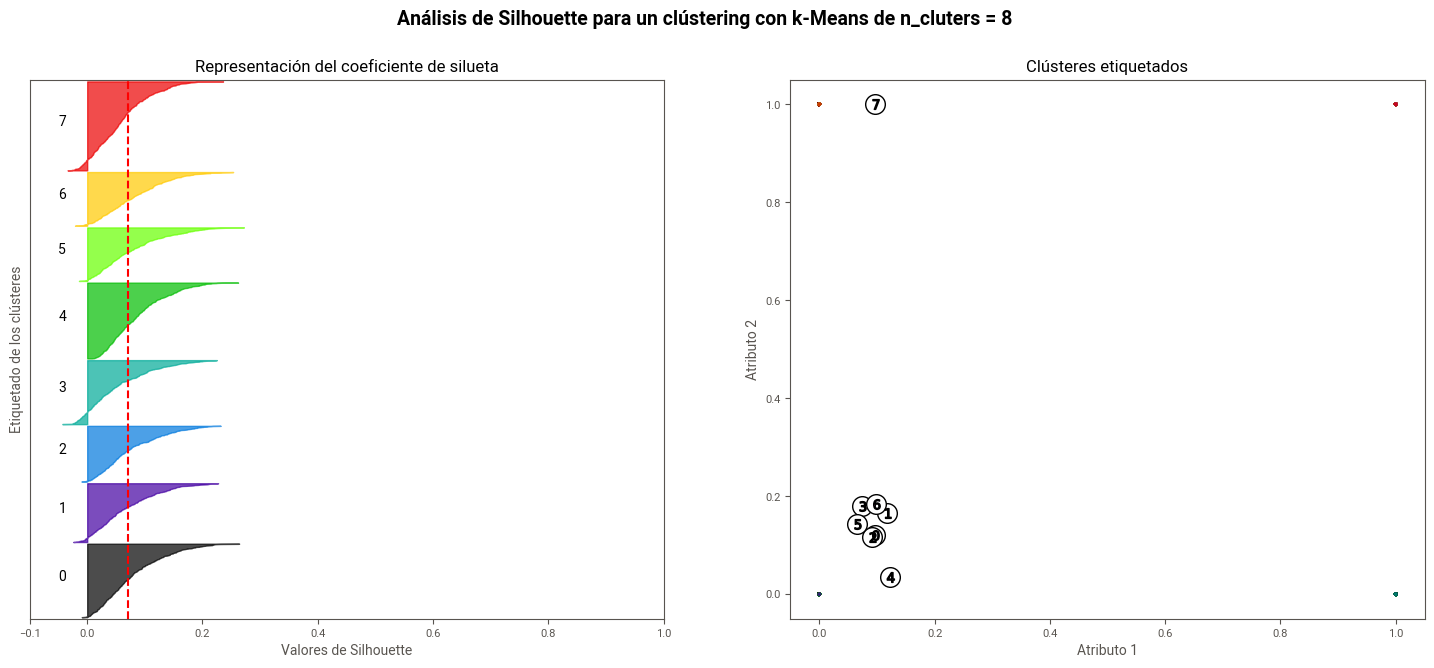

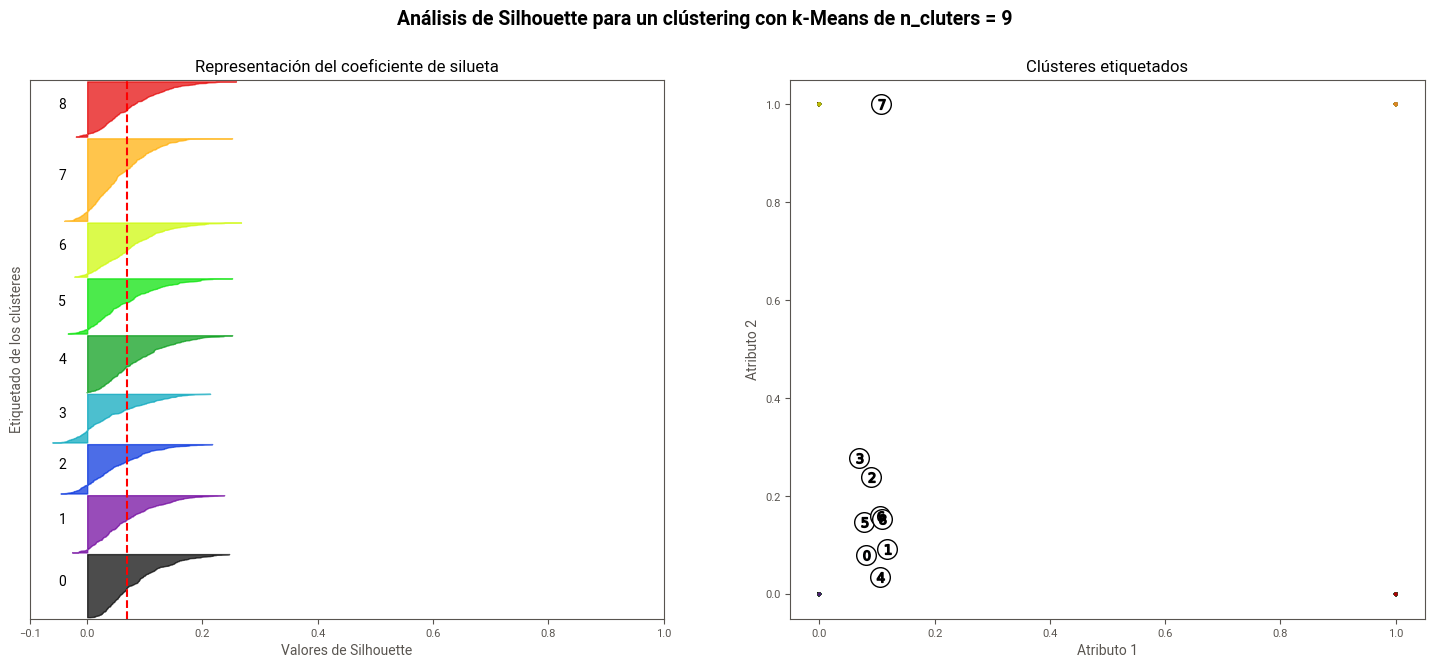

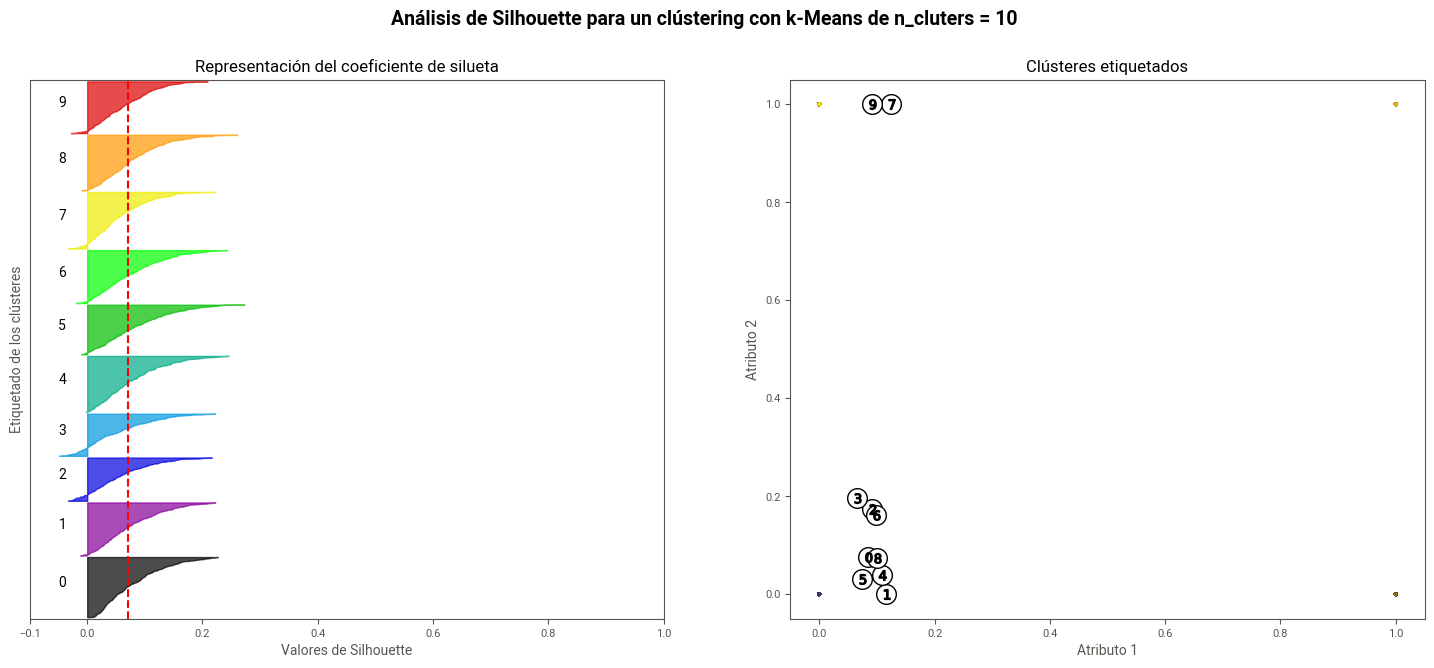

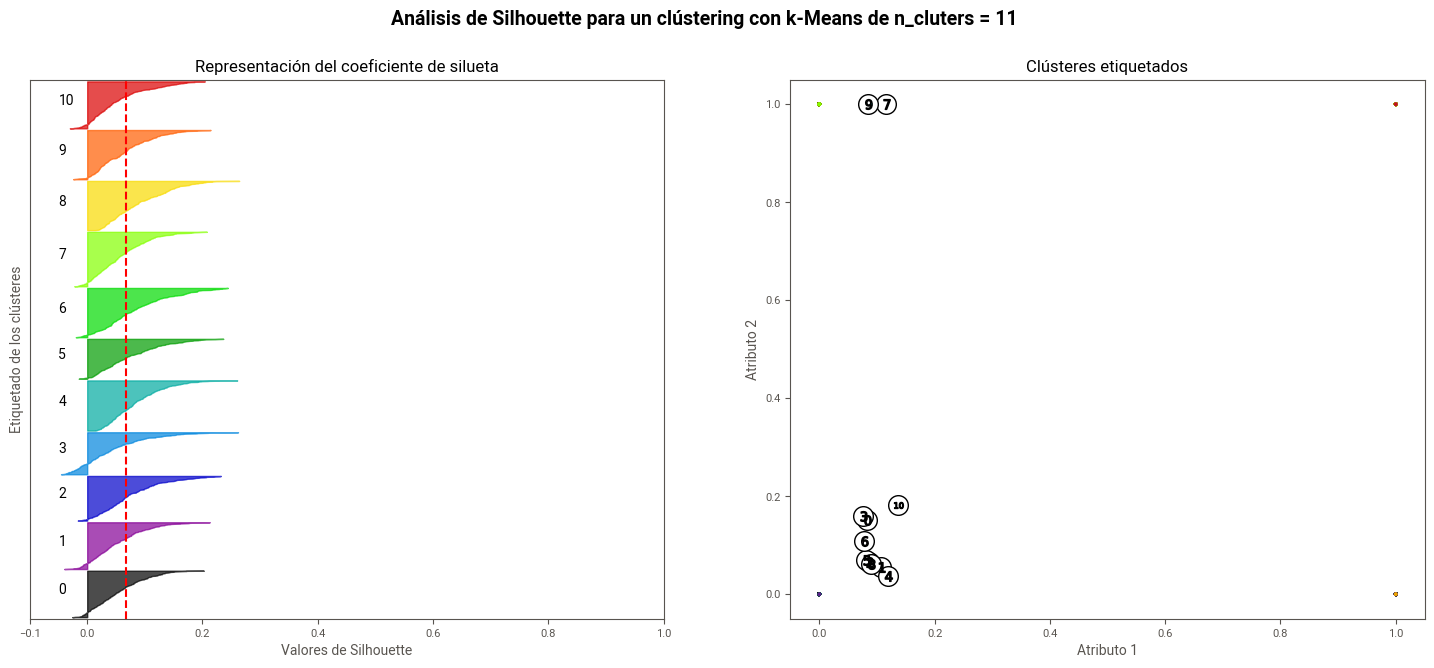

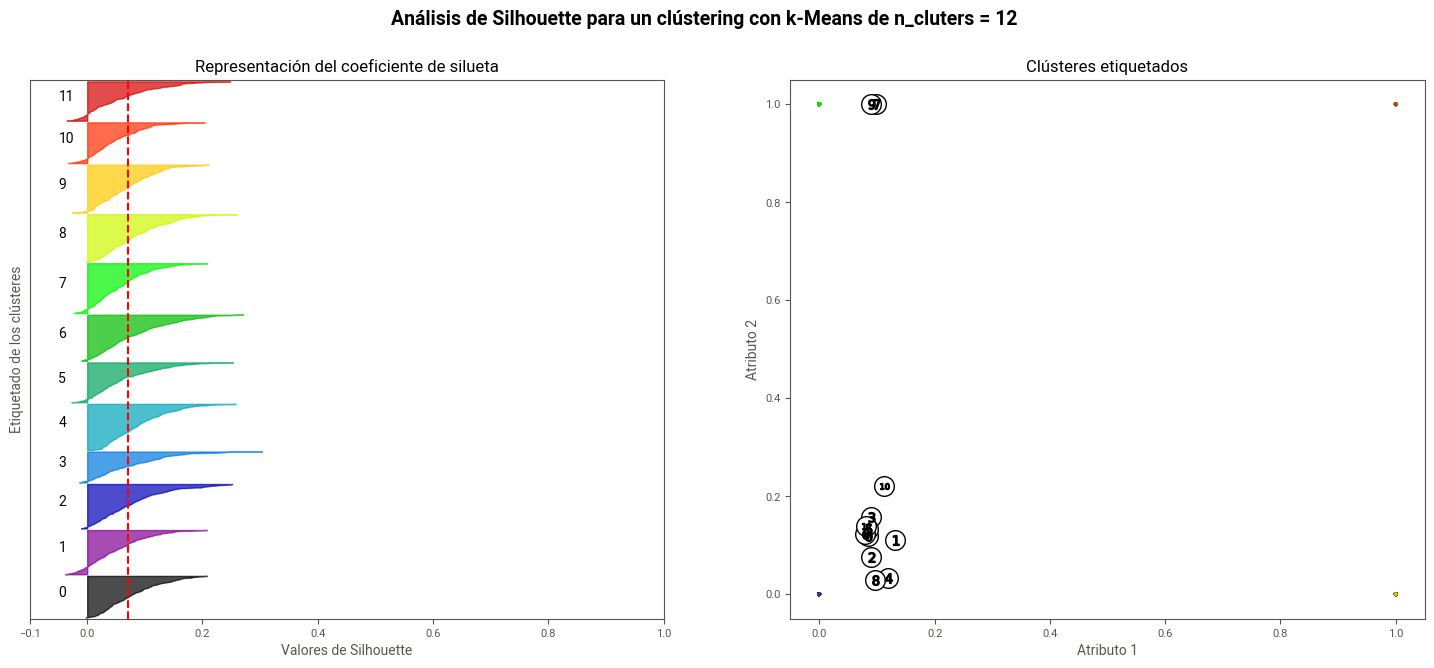

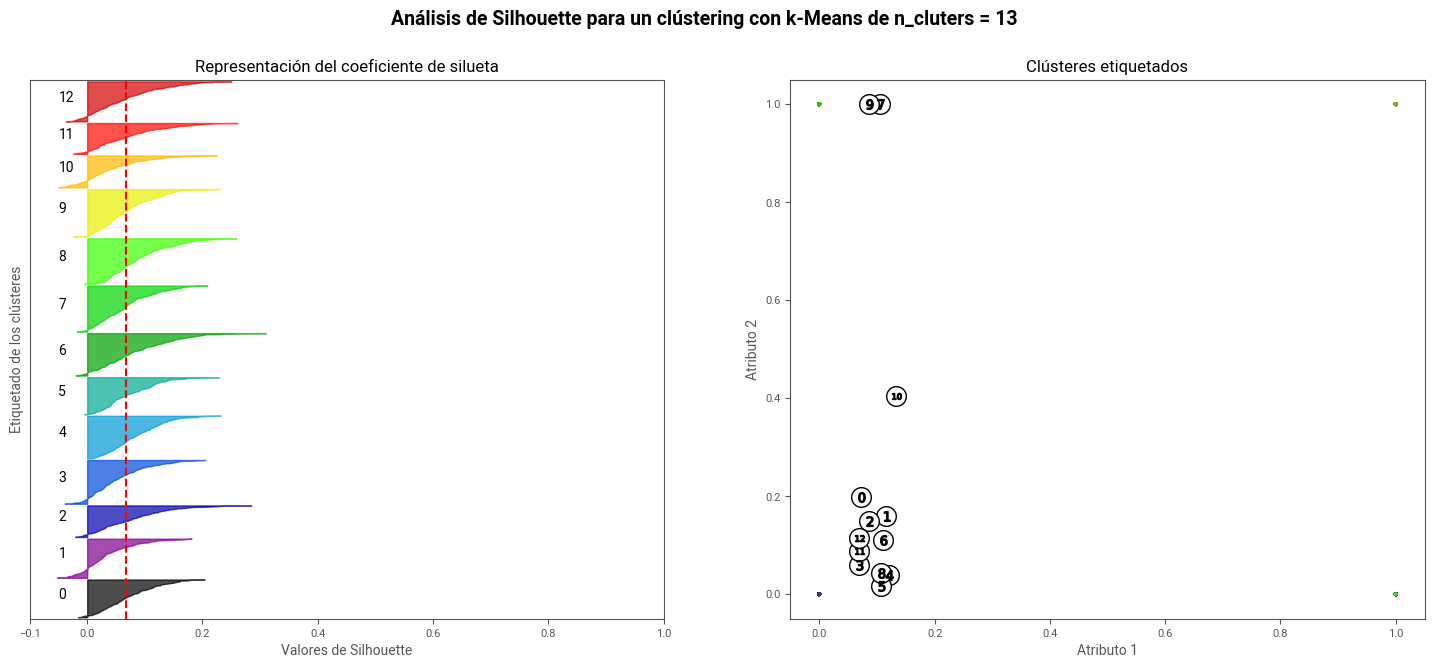

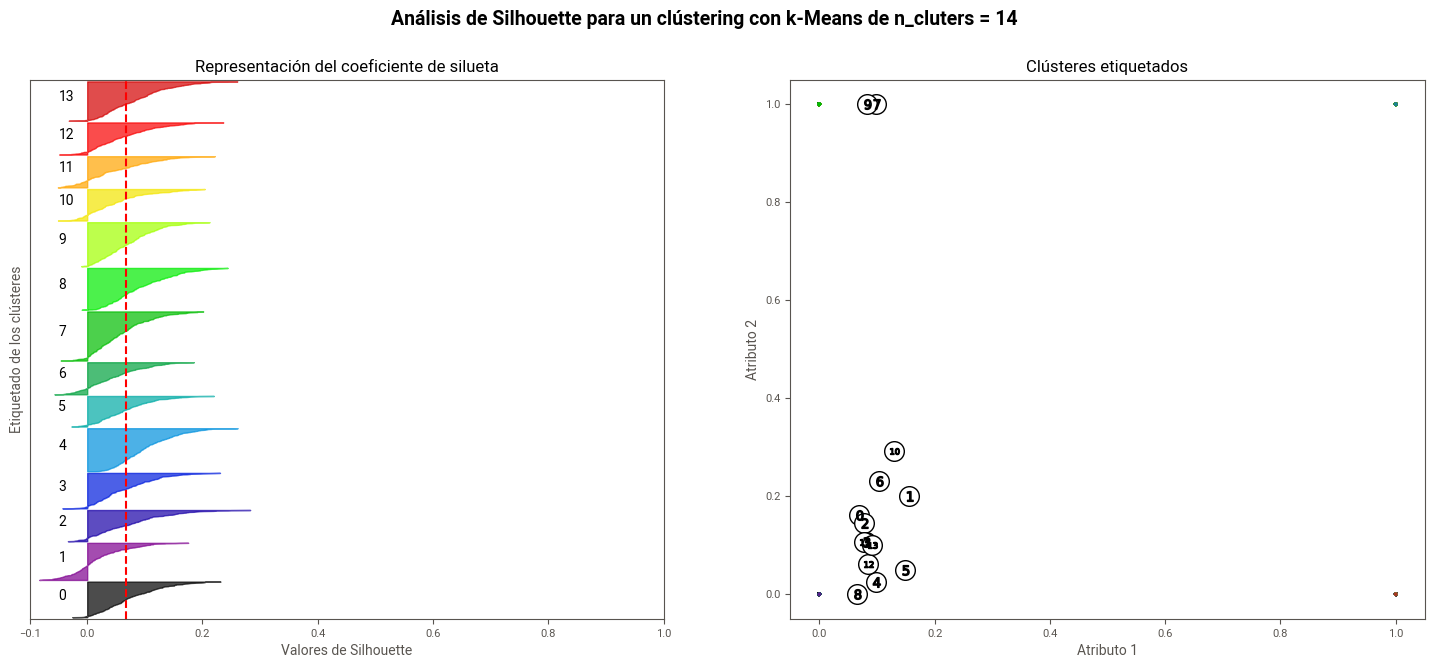

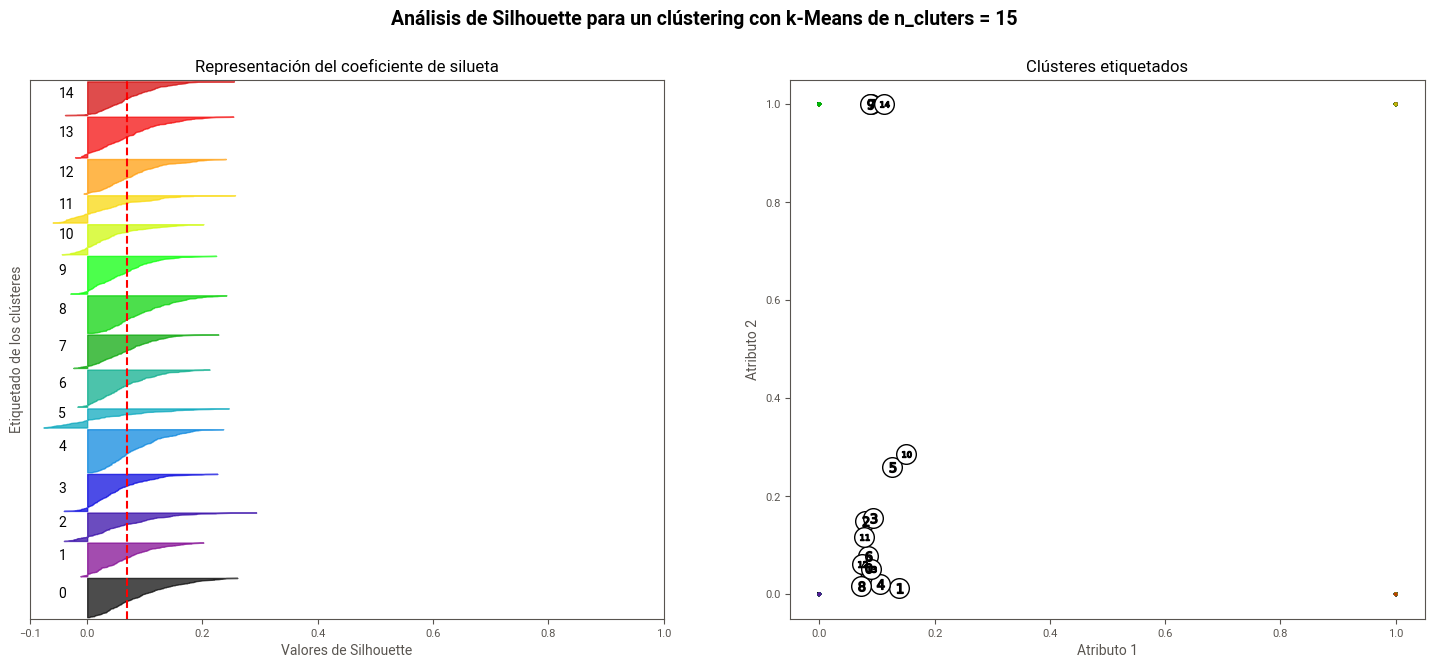

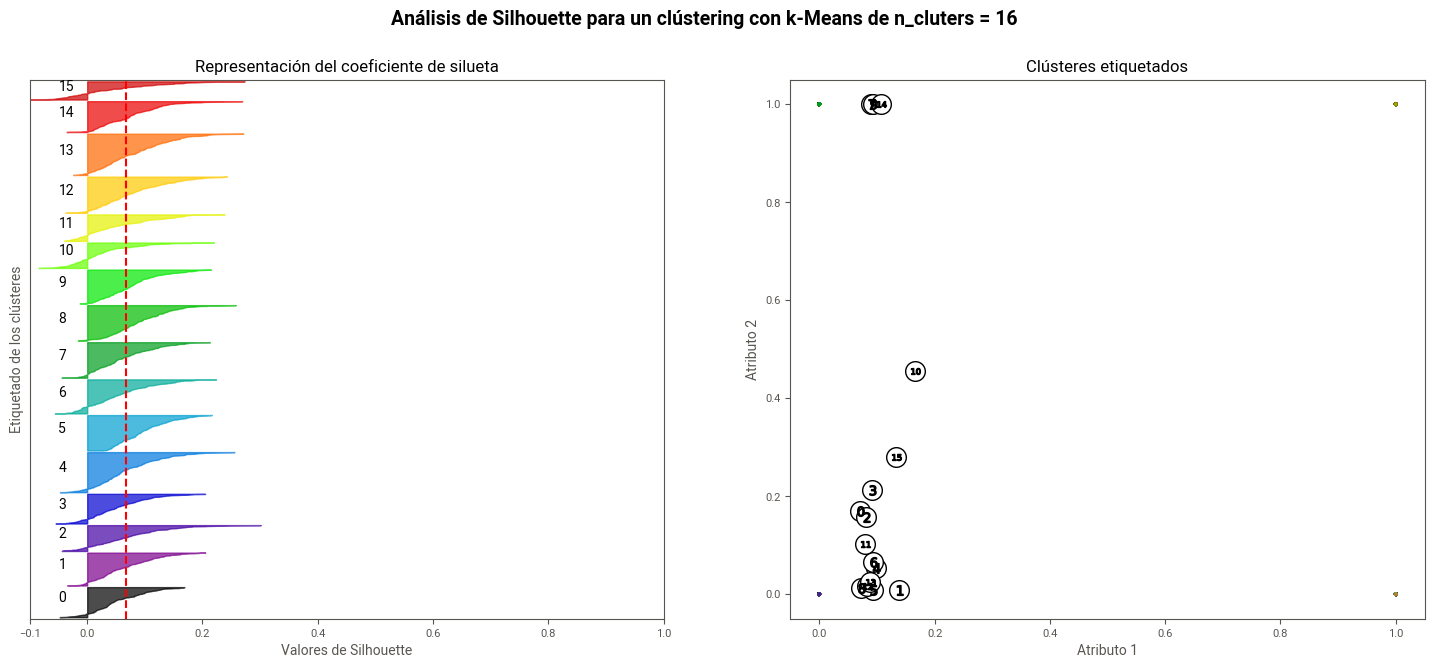

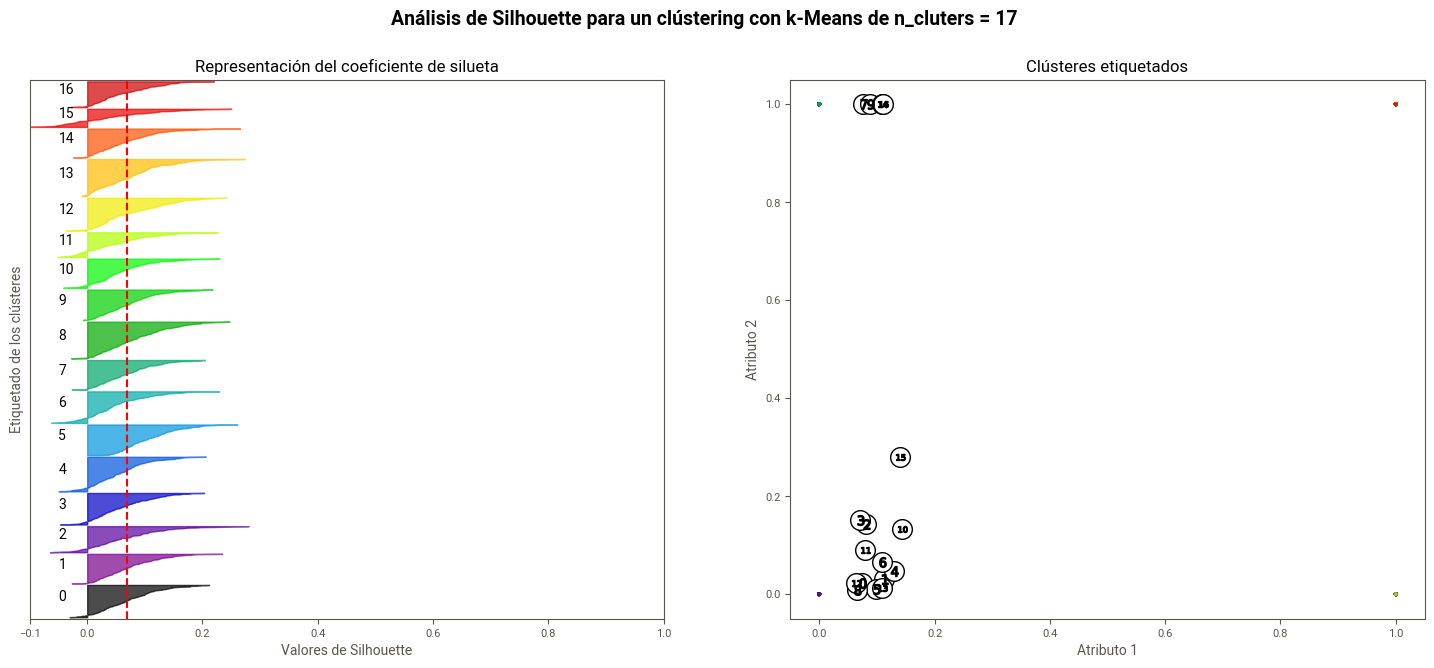

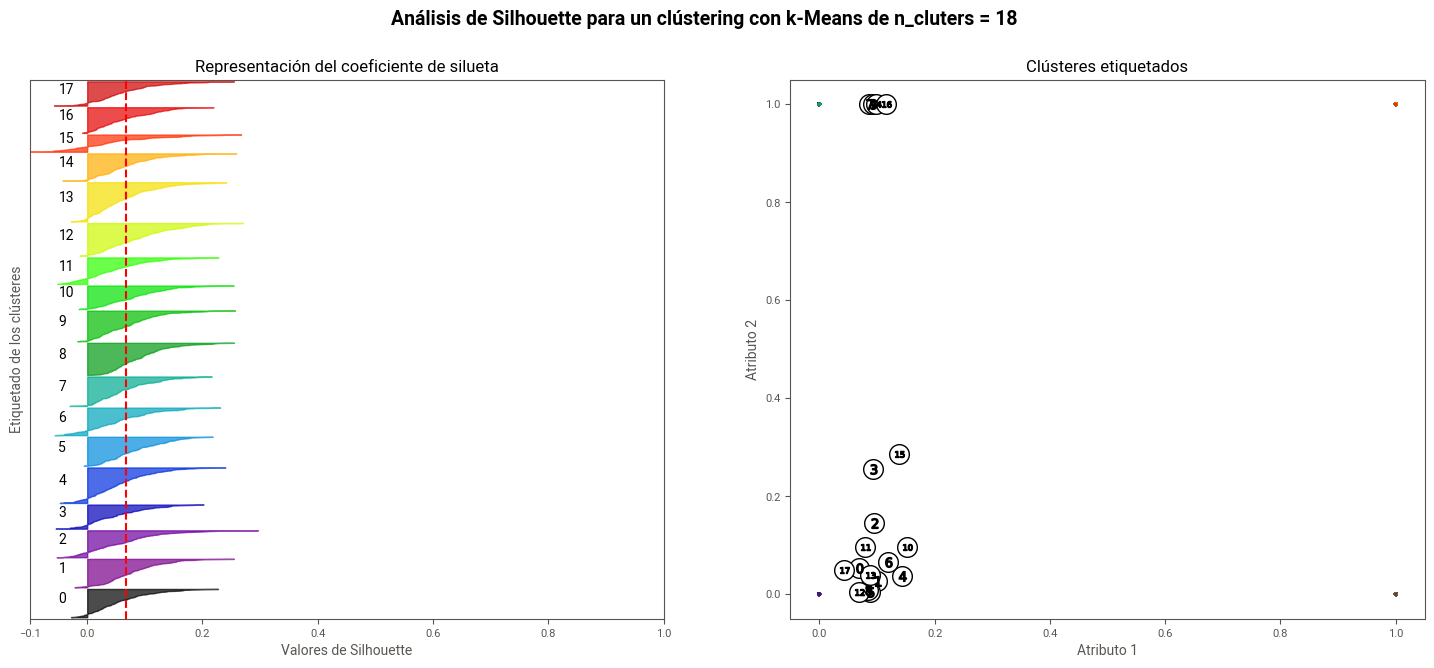

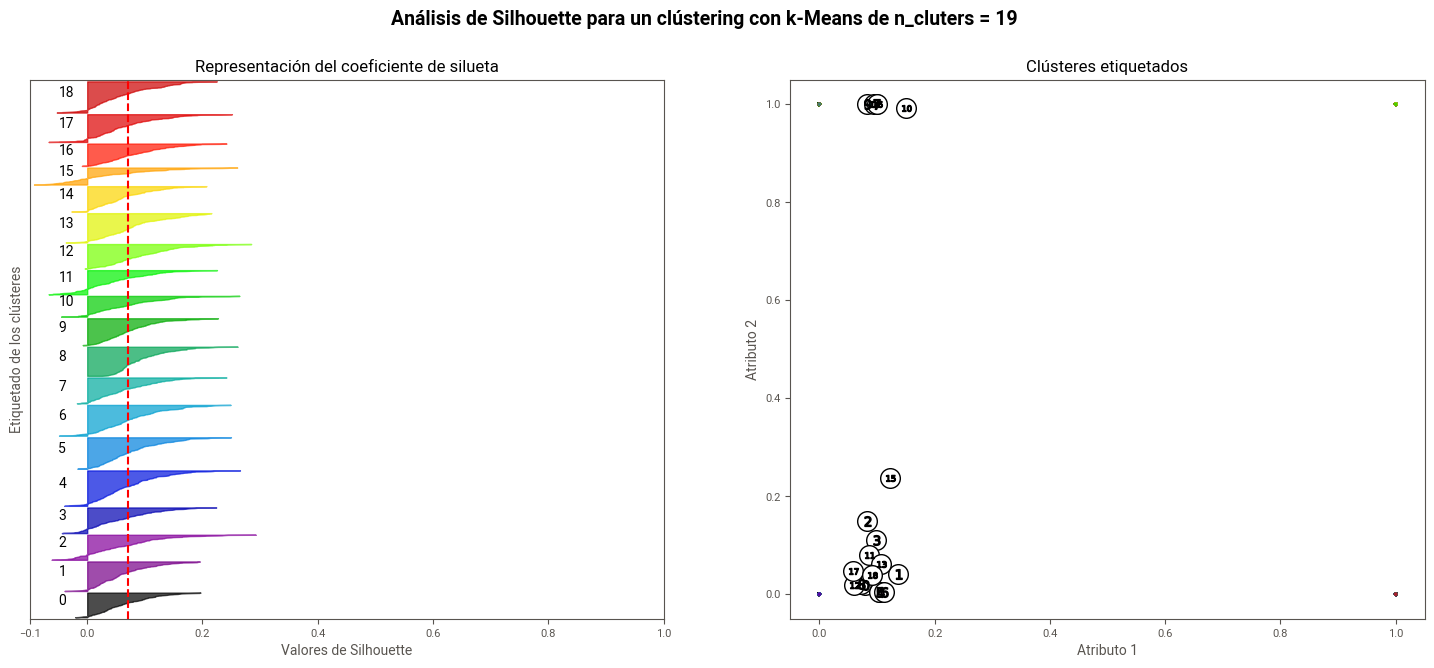

In [ ]:
X_numeric = X.select_dtypes(include=['float64', 'int64'])

range_n_clusters = list(range(2, 20))
silhouette_scores = []

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_numeric) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X_numeric)

    silhouette_avg = silhouette_score(X_numeric, cluster_labels)
    print("Para k =", n_clusters, ", S =", silhouette_avg)
    silhouette_scores.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(X_numeric, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Representación del coeficiente de silueta")
    ax1.set_xlabel("Valores de Silhouette")
    ax1.set_ylabel("Etiquetado de los clústeres")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_numeric.iloc[:, 0], X_numeric.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_

    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Clústeres etiquetados")
    ax2.set_xlabel("Atributo 1")
    ax2.set_ylabel("Atributo 2")

    plt.suptitle(
        "Análisis de Silhouette para un clústering con k-Means de n_cluters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



Al comparar diferentes clusterings (un mismo algoritmo de
clústering para diferentes números de clústeres, $k$) podemos
determinar el número óptimo ($k_{opt}$) a partir del valor promedio del
coeficiente de silhouette de todos los elementos.

En general, sobre el valor promedio del coeficiente de silueta para todos los clúters, se considera:

* $0.70-1.00$: Estructura de clústering robusta.
* $0.50-0.70$: Estructura de clústering razonable.
* $0.25 - 0.50$: Estructura de clústering débil.
* $< 0.25$: no se ha podido determinar una estructura clústering.

Por lo que, estos resultados no coinciden con la reducción de dimensionalidad hecha previamente.

Después del análisis hemos llegado a la conclusión de que no hemos encontrado ningún Kopt para realizar un clustering.

# Modelado


Para abordar el problema de desbalanceo de clases en la variable objetivo 'Churn', se implementaron varias estrategias. Primero, se calcularon pesos de clase balanceados utilizando la función compute_class_weight de sklearn, lo que ayuda al modelo a prestar más atención a la clase minoritaria durante el entrenamiento. Además, se aplicó un método de sobremuestreo para la clase minoritaria, duplicando sus instancias varias veces y concatenándolas al dataset original. Estas técnicas combinadas mejoran la capacidad del modelo para reconocer tanto la clase mayoritaria como la minoritaria, lo que resulta en predicciones más precisas y equilibradas.

In [40]:
classes = np.unique(df_filtered['Churn'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_filtered['Churn'])
class_weights = dict(enumerate(class_weights))

li = []
minority_class = df_filtered['Churn'].value_counts().idxmin()
for i in range(1,4):
    x = df_filtered[df_filtered['Churn'] == minority_class]
    li.append(x)
li.append(df_filtered)
df_filtered = pd.concat(li, axis=0, ignore_index=True)

In [41]:
df_filtered['Churn'].value_counts()

Churn
0    2903
1    1968
Name: count, dtype: int64

Vemos que se han equilibrado las clases.

Vamos a analizar diferentes modelos para abordar este problema

## Modelo de arboles

In [63]:
X = df_filtered.drop(['Churn'],axis=1)
y = df_filtered['Churn']

In [65]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier()

# Definir los hiperparámetros para el Grid Search
param_grid = {
    'n_estimators': [300, 600],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 7]
}

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_gb_model = grid_search.best_estimator_

y_pred = best_gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"Exactitud en el conjunto de prueba: {accuracy:.4f}")
print("Matriz de Confusión:")
print(conf_matrix)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores Hiperparámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 600}
Exactitud en el conjunto de prueba: 0.9887
Matriz de Confusión:
[[561  11]
 [  0 403]]


In [68]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_gb_model = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=600
)

y_pred_cv = cross_val_predict(best_gb_model, X_train, y_train, cv=5)

conf_matrix = confusion_matrix(y_train, y_pred_cv)

accuracy = accuracy_score(y_train, y_pred_cv)
report = classification_report(y_train, y_pred_cv)

print("Matriz de Confusión Global:")
print(conf_matrix)
print("\nExactitud Media:", accuracy)
print("\nReporte de Clasificación Medio:")
print(report)

Matriz de Confusión Global:
[[2286   45]
 [  14 1551]]

Exactitud Media: 0.9848562628336756

Reporte de Clasificación Medio:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2331
           1       0.97      0.99      0.98      1565

    accuracy                           0.98      3896
   macro avg       0.98      0.99      0.98      3896
weighted avg       0.99      0.98      0.98      3896



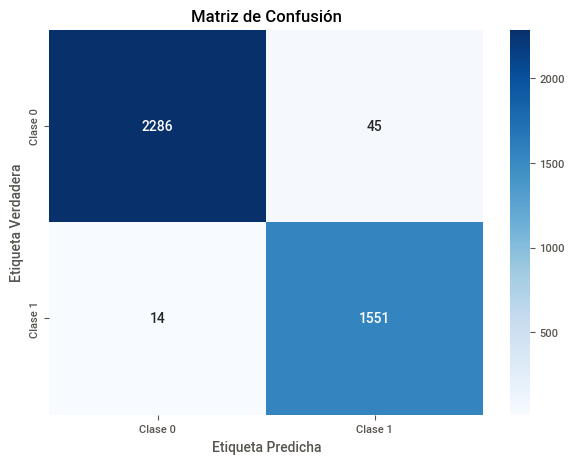

In [69]:
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

## Red neuronal

In [42]:
test_size = 0.3
val_size = 0.3
epochs = 200
batch_size = 256
target = 'Churn'

In [43]:
df_filtered = df_filtered.sample(frac=1)
train_df, test_df = train_test_split(df_filtered
                                     , test_size = test_size, random_state=0)
train_df, val_df = train_test_split(train_df
                                    , test_size = val_size, random_state=0)

train_features = np.array(train_df[train_df.columns.difference([target])])
val_features = np.array(val_df[val_df.columns.difference([target])])
test_features = np.array(test_df[test_df.columns.difference([target])])

train_labels = np.array(train_df[[target]])
val_labels = np.array(val_df[[target]])
test_labels = np.array(test_df[[target]])

input_len = train_features.shape[1]

shap_test_df = test_df.copy(deep = True)



Creamos una función con una red neuronal secuencial, con diferentes parametros que luego usaremos en el grid search, para buscar la mejor arquitectura

In [44]:
def make_model1(input_len, dense_layers, dense_units, dense_dropout, learning_rate, output_bias=None):
    model = Sequential()

    for units in dense_units:
        model.add(Dense(units=units,
                        input_dim=input_len,
                        kernel_initializer='he_normal',
                        activation='relu'))
        model.add(Dropout(rate=dense_dropout))

    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'

    model.add(Dense(units=1,
                    activation='sigmoid',
                    kernel_initializer='glorot_uniform',
                    bias_initializer=output_bias))

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

Aqui introducimos las diferentes pruebas de hiperparámetros que queremos hacer

In [45]:
dense_layers = [5]
dense_units = [[256, 256, 128, 64, 32],[256,128, 64, 32, 16]]
dense_dropout = [0.3,0.5]
learning_rate = [1e-3]
batch_size = [128,64]
epochs = [100]

In [46]:
def plot_history_train(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Proposed 8 models


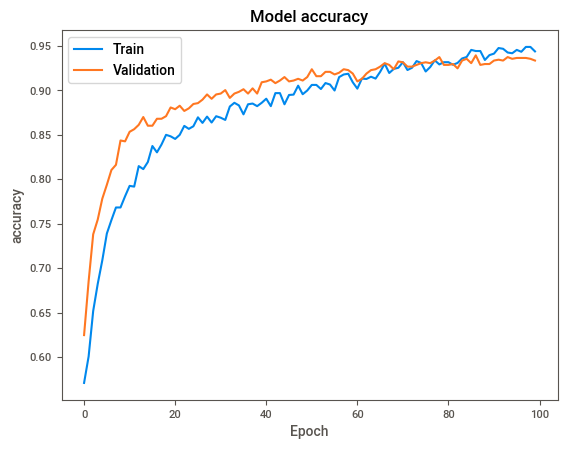

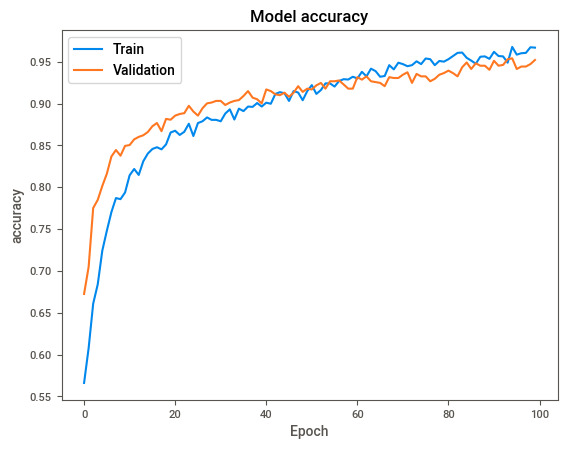

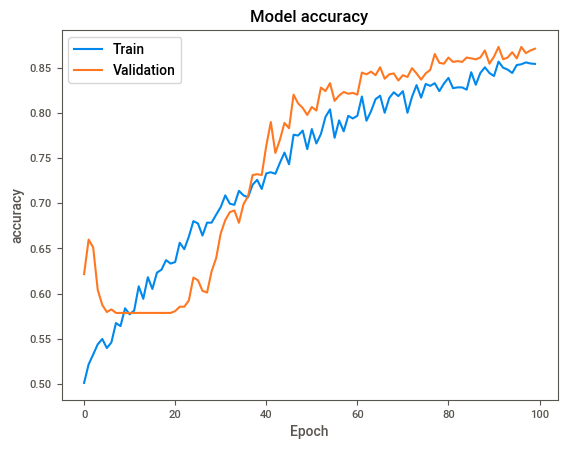

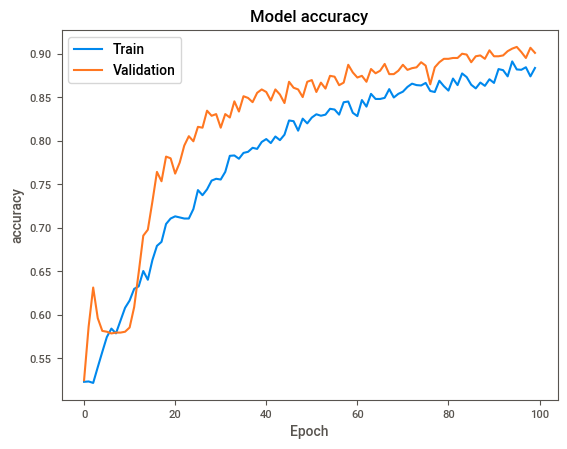

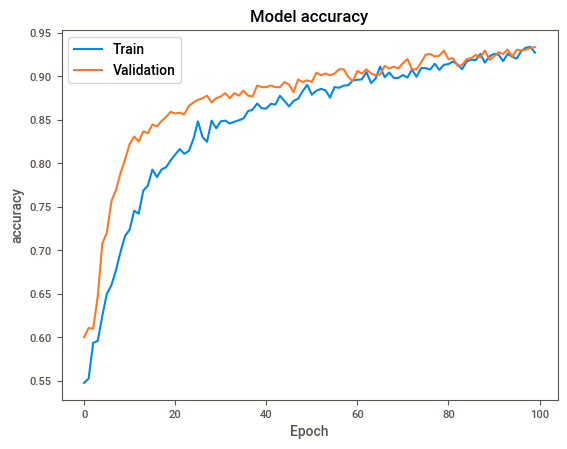

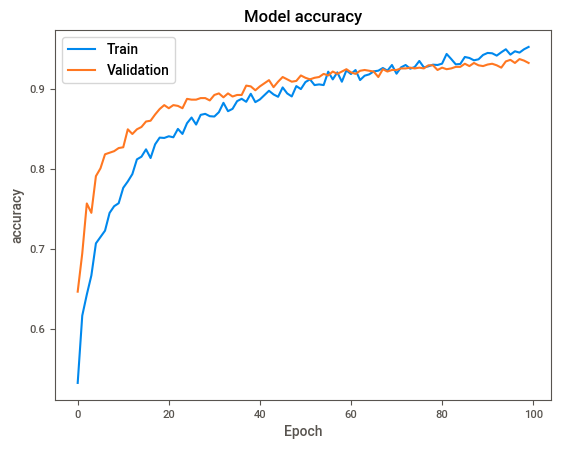

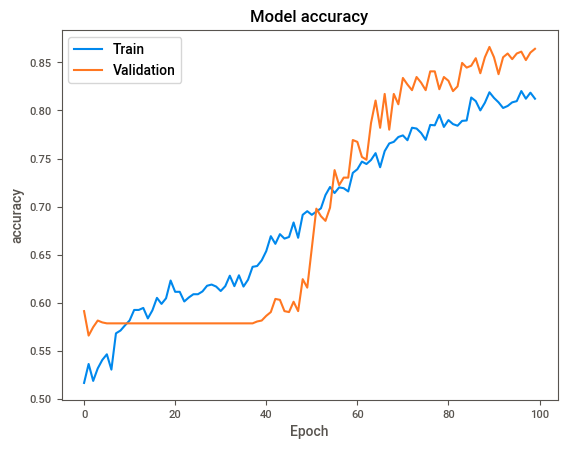

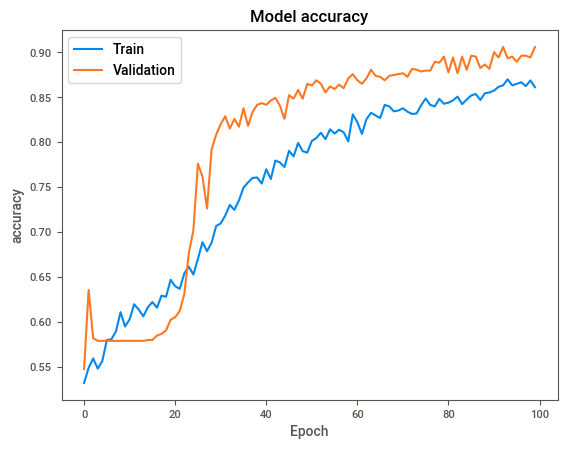

   dense_layers              dense_units  dense_dropout  learning_rate  \
0             5  [256, 256, 128, 64, 32]            0.3          0.001   
1             5  [256, 256, 128, 64, 32]            0.3          0.001   
2             5  [256, 256, 128, 64, 32]            0.5          0.001   
3             5  [256, 256, 128, 64, 32]            0.5          0.001   
4             5   [256, 128, 64, 32, 16]            0.3          0.001   
5             5   [256, 128, 64, 32, 16]            0.3          0.001   
6             5   [256, 128, 64, 32, 16]            0.5          0.001   
7             5   [256, 128, 64, 32, 16]            0.5          0.001   

   batch_size  epochs  val_accuracy  trpain_accuracy  
0         128     100      0.933529         0.943839  
1          64     100      0.952102         0.966890  
2         128     100      0.870968         0.854149  
3          64     100      0.901271         0.883906  
4         128     100      0.933529         0.927075  
5  

In [47]:
param_grid = dict(dense_layers=dense_layers,
                  dense_units=dense_units,
                  dense_dropout=dense_dropout,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  epochs=epochs)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

results = []

for params in param_grid:
    dense_layers = params['dense_layers']
    dense_units = params['dense_units']
    dense_dropout = params['dense_dropout']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = make_model1(input_len=input_len,
                        dense_layers=dense_layers,
                        dense_units=dense_units,
                        dense_dropout=dense_dropout,
                        learning_rate=learning_rate)

    history = model.fit(train_features, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(val_features, val_labels),
                        verbose=0)

    plot_history_train(history, 'accuracy')

    val_acc = pd.DataFrame(history.history)['val_accuracy'].iloc[-1]
    train_acc = pd.DataFrame(history.history)['accuracy'].iloc[-1]
    params.update({"val_accuracy": val_acc})
    params.update({"trpain_accuracy": train_acc})

    results.append(params)

results_df = pd.DataFrame(results)
print(results_df)

El modelo seleccionado, con 5 capas densas y unidades [256, 128, 64, 32, 16], tasa de dropout de 0.3, tasa de aprendizaje de 0.001, tamaño del lote de 64, y 100 épocas, mostró el mejor rendimiento en términos de precisión de validación. Esta configuración ofrece un equilibrio óptimo entre la capacidad de generalización y el ajuste del modelo, lo que lo hace adecuado para el problema de clasificación binaria en cuestión.

In [50]:
model_5_params = results[1]
print("Parámetros del modelo 5:", model_5_params)

Parámetros del modelo 5: {'dense_layers': 5, 'dense_units': [256, 256, 128, 64, 32], 'dense_dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'val_accuracy': 0.9521016478538513, 'trpain_accuracy': 0.9668902158737183}


In [53]:
model_5 = make_model1(input_len=input_len,
                      dense_layers=model_5_params['dense_layers'],
                      dense_units=model_5_params['dense_units'],
                      dense_dropout=model_5_params['dense_dropout'],
                      learning_rate=model_5_params['learning_rate'])

model_5.fit(train_features, train_labels, batch_size=model_5_params['batch_size'], epochs=model_5_params['epochs'], validation_data=(val_features, val_labels), verbose=0)

In [54]:
y_pred = model_5.predict(train_features)
y_pred = (y_pred > 0.5).astype(int)

75/75 [==============================] - 0s 2ms/step


In [58]:
cm = confusion_matrix(train_labels, y_pred)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[1449    4]
 [   4  929]]


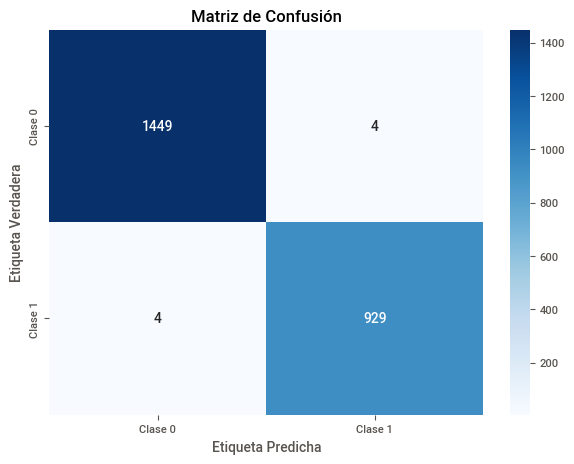

In [59]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()